In [115]:
# Tratamiento de datos
import numpy as np
import pandas as pd

# Conexi√≥n SQL Server
import pyodbc

# Manejo de fechas y ambiente
from datetime import datetime
import os

# Gr√°ficos
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import plotly.express as px

# Modelado y forecasting
from prophet import Prophet
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from skforecast.model_selection import backtesting_forecaster, grid_search_forecaster

In [2]:
# Warnings y estilos
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5

# Para notebooks (opcional)
%matplotlib inline

In [3]:
import contextlib
import sys
@contextlib.contextmanager
def suppress_stdout_stderr():
    with open(os.devnull, 'w') as fnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = fnull
        sys.stderr = fnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

In [ ]:
# Cargar ambos datasets
df_train = pd.read_csv('./data/train.csv', parse_dates=['Dates'])
df_test = pd.read_csv('./data/test.csv', parse_dates=['Dates'])

# Unir los datasets
df = pd.concat([df_train, df_test], ignore_index=True)

# Ordenar cronol√≥gicamente
df = df.sort_values(by='Dates').reset_index(drop=True)

In [5]:
df_test = df.drop(columns=['Category', 'Descript', 'Resolution', 'Address', 'DayOfWeek', 'Id'])

In [6]:
df_test.rename(columns={'Dates': 'Datetime'}, inplace=True)

In [7]:
df_test

Datetime PdDistrict           X          Y
0       2003-01-01 00:01:00    TARAVAL -122.489714  37.733950
1       2003-01-01 00:01:00    CENTRAL -122.404282  37.798225
2       2003-01-01 00:01:00    BAYVIEW -122.397700  37.740576
3       2003-01-01 00:01:00   SOUTHERN -122.424745  37.770254
4       2003-01-01 00:01:00    MISSION -122.419971  37.767454
...                     ...        ...         ...        ...
1762306 2015-05-13 23:30:00  INGLESIDE -122.423327  37.725138
1762307 2015-05-13 23:30:00  INGLESIDE -122.403252  37.713431
1762308 2015-05-13 23:33:00   NORTHERN -122.424363  37.800414
1762309 2015-05-13 23:53:00   NORTHERN -122.425892  37.774599
1762310 2015-05-13 23:53:00   NORTHERN -122.425892  37.774599

[1762311 rows x 4 columns]

### An√°lisis de completitud de la serie temporal para el distrito SOUTHERN

In [8]:
# Filtrar datos del distrito SOUTHERN
southern_data = df_test[df_test['PdDistrict'] == 'SOUTHERN'].copy()

print("An√°lisis de completitud de la serie temporal para el distrito SOUTHERN")
print("=" * 60)
print(f"Total de registros en SOUTHERN: {len(southern_data)}")
print(f"Rango de fechas: {southern_data['Datetime'].min()} a {southern_data['Datetime'].max()}")

# Agrupar por d√≠a para ver la distribuci√≥n temporal
southern_daily = southern_data.groupby(southern_data['Datetime'].dt.date).size().reset_index()
southern_daily.columns = ['Date', 'Count']
southern_daily['Date'] = pd.to_datetime(southern_daily['Date'])

print(f"\nTotal de d√≠as √∫nicos con registros: {len(southern_daily)}")

# Calcular el rango completo de fechas esperado
fecha_inicio = southern_daily['Date'].min()
fecha_fin = southern_daily['Date'].max()
total_dias_esperados = (fecha_fin - fecha_inicio).days + 1

print(f"D√≠as esperados en el rango completo: {total_dias_esperados}")
print(f"D√≠as con registros: {len(southern_daily)}")
print(f"D√≠as faltantes: {total_dias_esperados - len(southern_daily)}")
print(f"Porcentaje de completitud: {len(southern_daily) / total_dias_esperados * 100:.2f}%")

An√°lisis de completitud de la serie temporal para el distrito SOUTHERN
Total de registros en SOUTHERN: 314638
Rango de fechas: 2003-01-01 00:01:00 a 2015-05-13 20:30:00

Total de d√≠as √∫nicos con registros: 4513
D√≠as esperados en el rango completo: 4516
D√≠as con registros: 4513
D√≠as faltantes: 3
Porcentaje de completitud: 99.93%


In [9]:
# Crear rango completo de fechas esperado
fecha_completa = pd.date_range(start=fecha_inicio, end=fecha_fin, freq='D')
fechas_completas = pd.DataFrame({'Date': fecha_completa})

# Identificar d√≠as faltantes
fechas_con_datos = set(southern_daily['Date'].dt.date)
fechas_esperadas = set(fecha_completa.date)
fechas_faltantes = fechas_esperadas - fechas_con_datos

print("\nD√≠as faltantes:")
for fecha in sorted(fechas_faltantes):
    print(f"  - {fecha}")

# Estad√≠sticas de registros por d√≠a
print(f"\nEstad√≠sticas de registros por d√≠a en SOUTHERN:")
print(f"Promedio de registros por d√≠a: {southern_daily['Count'].mean():.1f}")
print(f"Mediana de registros por d√≠a: {southern_daily['Count'].median():.1f}")
print(f"M√≠nimo de registros por d√≠a: {southern_daily['Count'].min()}")
print(f"M√°ximo de registros por d√≠a: {southern_daily['Count'].max()}")
print(f"Desviaci√≥n est√°ndar: {southern_daily['Count'].std():.1f}")

# D√≠as con muy pocos registros (posibles anomal√≠as)
dias_pocos_registros = southern_daily[southern_daily['Count'] < 10]
print(f"\nD√≠as con menos de 10 registros: {len(dias_pocos_registros)}")
if len(dias_pocos_registros) > 0:
    print("Fechas con pocos registros:")
    for _, row in dias_pocos_registros.iterrows():
        print(f"  - {row['Date'].date()}: {row['Count']} registros")


D√≠as faltantes:
  - 2007-12-16
  - 2008-08-01
  - 2009-06-10

Estad√≠sticas de registros por d√≠a en SOUTHERN:
Promedio de registros por d√≠a: 69.7
Mediana de registros por d√≠a: 69.0
M√≠nimo de registros por d√≠a: 19
M√°ximo de registros por d√≠a: 198
Desviaci√≥n est√°ndar: 15.0

D√≠as con menos de 10 registros: 0


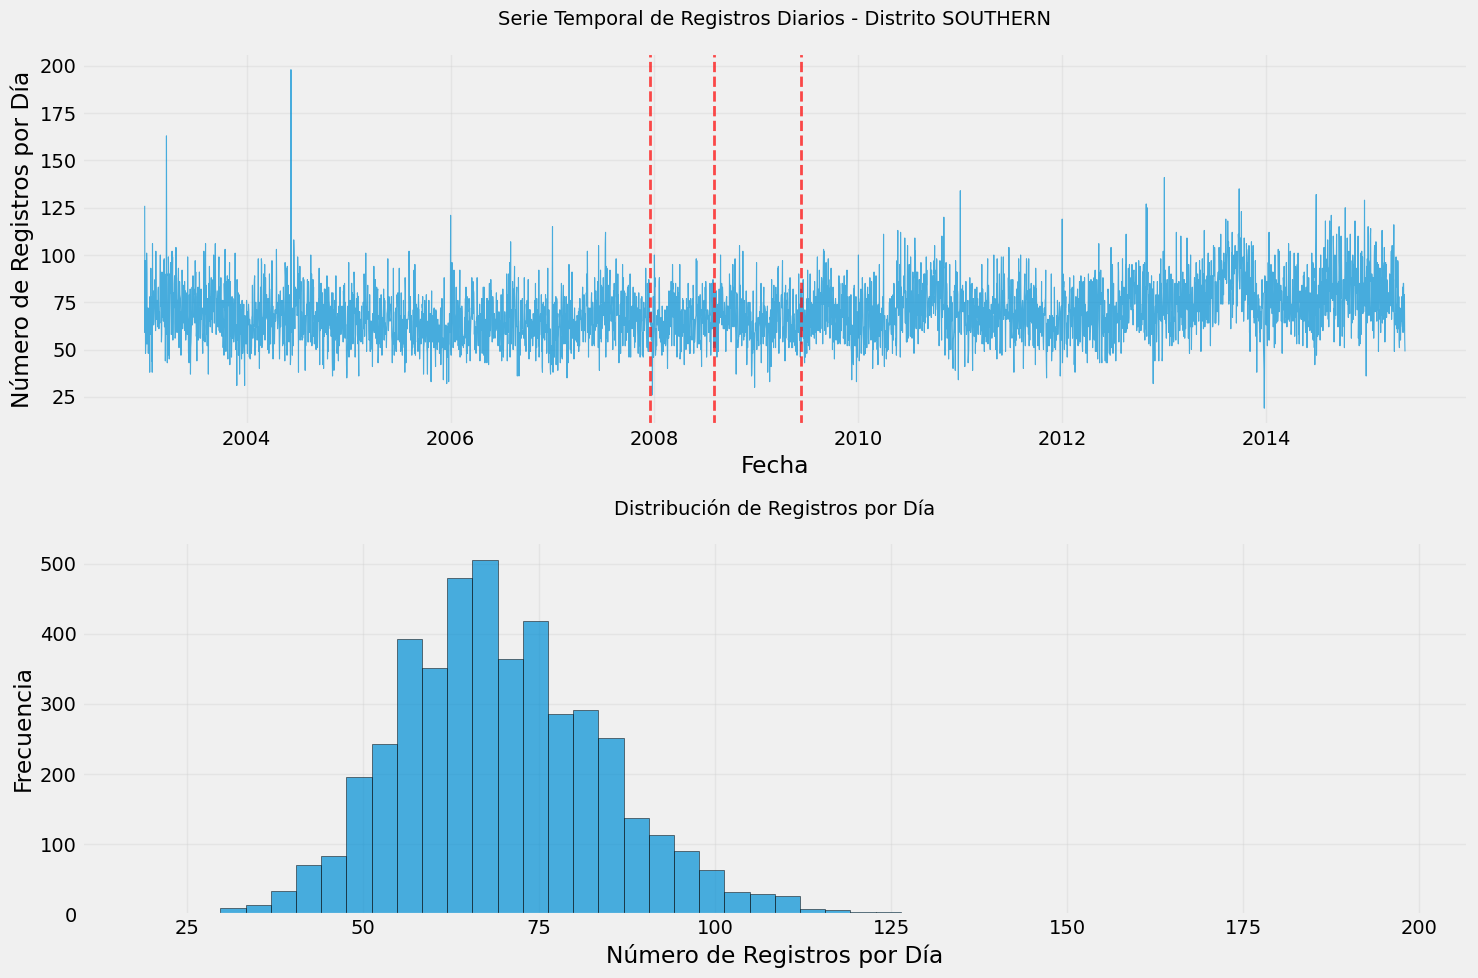


RESUMEN DEL AN√ÅLISIS DE COMPLETITUD - DISTRITO SOUTHERN
üìä Total de registros: 314,638
üìÖ Per√≠odo: 2003-01-01 a 2015-05-13
‚è±Ô∏è  Duraci√≥n: 4,516 d√≠as (12.4 a√±os)
‚úÖ D√≠as con datos: 4,513
‚ùå D√≠as faltantes: 3
üìà Completitud: 99.93%
üìä Promedio registros/d√≠a: 69.7
üìâ Rango registros/d√≠a: 19 - 198

üîç D√≠as espec√≠ficos faltantes:
   ‚Ä¢ 2007-12-16
   ‚Ä¢ 2008-08-01
   ‚Ä¢ 2009-06-10

üí° Conclusi√≥n: La serie temporal est√° muy completa (99.93%)
   Solo faltan 3 d√≠as de 4,516 d√≠as totales.


In [10]:
# Visualizaci√≥n de la serie temporal
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Gr√°fico 1: Serie temporal completa
ax1.plot(southern_daily['Date'], southern_daily['Count'], linewidth=0.8, alpha=0.7)
ax1.set_title('Serie Temporal de Registros Diarios - Distrito SOUTHERN', fontsize=14, pad=20)
ax1.set_xlabel('Fecha')
ax1.set_ylabel('N√∫mero de Registros por D√≠a')
ax1.grid(True, alpha=0.3)

# Marcar los d√≠as faltantes
for fecha in sorted(fechas_faltantes):
    ax1.axvline(x=pd.to_datetime(fecha), color='red', linestyle='--', alpha=0.7, linewidth=2)

# Gr√°fico 2: Histograma de registros por d√≠a
ax2.hist(southern_daily['Count'], bins=50, alpha=0.7, edgecolor='black', linewidth=0.5)
ax2.set_title('Distribuci√≥n de Registros por D√≠a', fontsize=14, pad=20)
ax2.set_xlabel('N√∫mero de Registros por D√≠a')
ax2.set_ylabel('Frecuencia')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Resumen final
print("\n" + "="*60)
print("RESUMEN DEL AN√ÅLISIS DE COMPLETITUD - DISTRITO SOUTHERN")
print("="*60)
print(f"üìä Total de registros: {len(southern_data):,}")
print(f"üìÖ Per√≠odo: {fecha_inicio.date()} a {fecha_fin.date()}")
print(f"‚è±Ô∏è  Duraci√≥n: {total_dias_esperados:,} d√≠as ({total_dias_esperados/365.25:.1f} a√±os)")
print(f"‚úÖ D√≠as con datos: {len(southern_daily):,}")
print(f"‚ùå D√≠as faltantes: {len(fechas_faltantes)}")
print(f"üìà Completitud: {len(southern_daily) / total_dias_esperados * 100:.2f}%")
print(f"üìä Promedio registros/d√≠a: {southern_daily['Count'].mean():.1f}")
print(f"üìâ Rango registros/d√≠a: {southern_daily['Count'].min()} - {southern_daily['Count'].max()}")

if len(fechas_faltantes) > 0:
    print(f"\nüîç D√≠as espec√≠ficos faltantes:")
    for fecha in sorted(fechas_faltantes):
        print(f"   ‚Ä¢ {fecha}")
        
print(f"\nüí° Conclusi√≥n: La serie temporal est√° muy completa ({len(southern_daily) / total_dias_esperados * 100:.2f}%)")
print(f"   Solo faltan {len(fechas_faltantes)} d√≠as de {total_dias_esperados:,} d√≠as totales.")

### An√°lisis a nivel de horas - Distrito SOUTHERN

In [11]:
# AN√ÅLISIS A NIVEL DE HORAS - DISTRITO SOUTHERN
print("AN√ÅLISIS TEMPORAL POR HORAS - DISTRITO SOUTHERN")
print("=" * 60)

# Extraer informaci√≥n de hora, d√≠a de la semana, etc.
southern_data['Hour'] = southern_data['Datetime'].dt.hour
southern_data['DayOfWeek'] = southern_data['Datetime'].dt.dayofweek  # 0=Lunes, 6=Domingo
southern_data['DayName'] = southern_data['Datetime'].dt.strftime('%A')
southern_data['Month'] = southern_data['Datetime'].dt.month
southern_data['Year'] = southern_data['Datetime'].dt.year

# An√°lisis por horas
hourly_counts = southern_data.groupby('Hour').size()
print(f"\nRegistros por hora del d√≠a:")
for hour in range(24):
    count = hourly_counts.get(hour, 0)
    percentage = (count / len(southern_data)) * 100
    print(f"  {hour:02d}:00 - {count:,} registros ({percentage:.1f}%)")

print(f"\nEstad√≠sticas por horas:")
print(f"Hora con m√°s registros: {hourly_counts.idxmax()}:00 ({hourly_counts.max():,} registros)")
print(f"Hora con menos registros: {hourly_counts.idxmin()}:00 ({hourly_counts.min():,} registros)")
print(f"Promedio de registros por hora: {hourly_counts.mean():.1f}")
print(f"Desviaci√≥n est√°ndar: {hourly_counts.std():.1f}")

# An√°lisis por d√≠a de la semana
day_names = ['Lunes', 'Martes', 'Mi√©rcoles', 'Jueves', 'Viernes', 'S√°bado', 'Domingo']
daily_counts = southern_data.groupby('DayOfWeek').size()
print(f"\nRegistros por d√≠a de la semana:")
for day_idx, day_name in enumerate(day_names):
    count = daily_counts.get(day_idx, 0)
    percentage = (count / len(southern_data)) * 100
    print(f"  {day_name}: {count:,} registros ({percentage:.1f}%)")

AN√ÅLISIS TEMPORAL POR HORAS - DISTRITO SOUTHERN

Registros por hora del d√≠a:
  00:00 - 16,186 registros (5.1%)
  01:00 - 8,977 registros (2.9%)
  02:00 - 7,536 registros (2.4%)
  03:00 - 4,451 registros (1.4%)
  04:00 - 3,084 registros (1.0%)
  05:00 - 2,624 registros (0.8%)
  06:00 - 4,305 registros (1.4%)
  07:00 - 7,255 registros (2.3%)
  08:00 - 11,502 registros (3.7%)
  09:00 - 13,335 registros (4.2%)
  10:00 - 14,064 registros (4.5%)
  11:00 - 14,146 registros (4.5%)
  12:00 - 18,568 registros (5.9%)
  13:00 - 16,695 registros (5.3%)
  14:00 - 17,146 registros (5.4%)
  15:00 - 17,641 registros (5.6%)
  16:00 - 18,422 registros (5.9%)
  17:00 - 19,652 registros (6.2%)
  18:00 - 20,295 registros (6.5%)
  19:00 - 18,284 registros (5.8%)
  20:00 - 15,929 registros (5.1%)
  21:00 - 14,606 registros (4.6%)
  22:00 - 15,255 registros (4.8%)
  23:00 - 14,680 registros (4.7%)

Estad√≠sticas por horas:
Hora con m√°s registros: 18:00 (20,295 registros)
Hora con menos registros: 5:00 (2,62

AN√ÅLISIS DE COMPLETITUD POR HORAS
Total de horas esperadas: 108,361
Horas con datos: 88,964
Horas faltantes: 19,397
Completitud por horas: 82.10%

Horas con 0 registros: 19,413

Estad√≠sticas de registros por hora espec√≠fica:
Promedio de registros por hora: 3.5
Mediana de registros por hora: 3.0
M√≠nimo de registros por hora: 1
M√°ximo de registros por hora: 38
Desviaci√≥n est√°ndar: 2.4

Horas con solo 1 registro: 19161


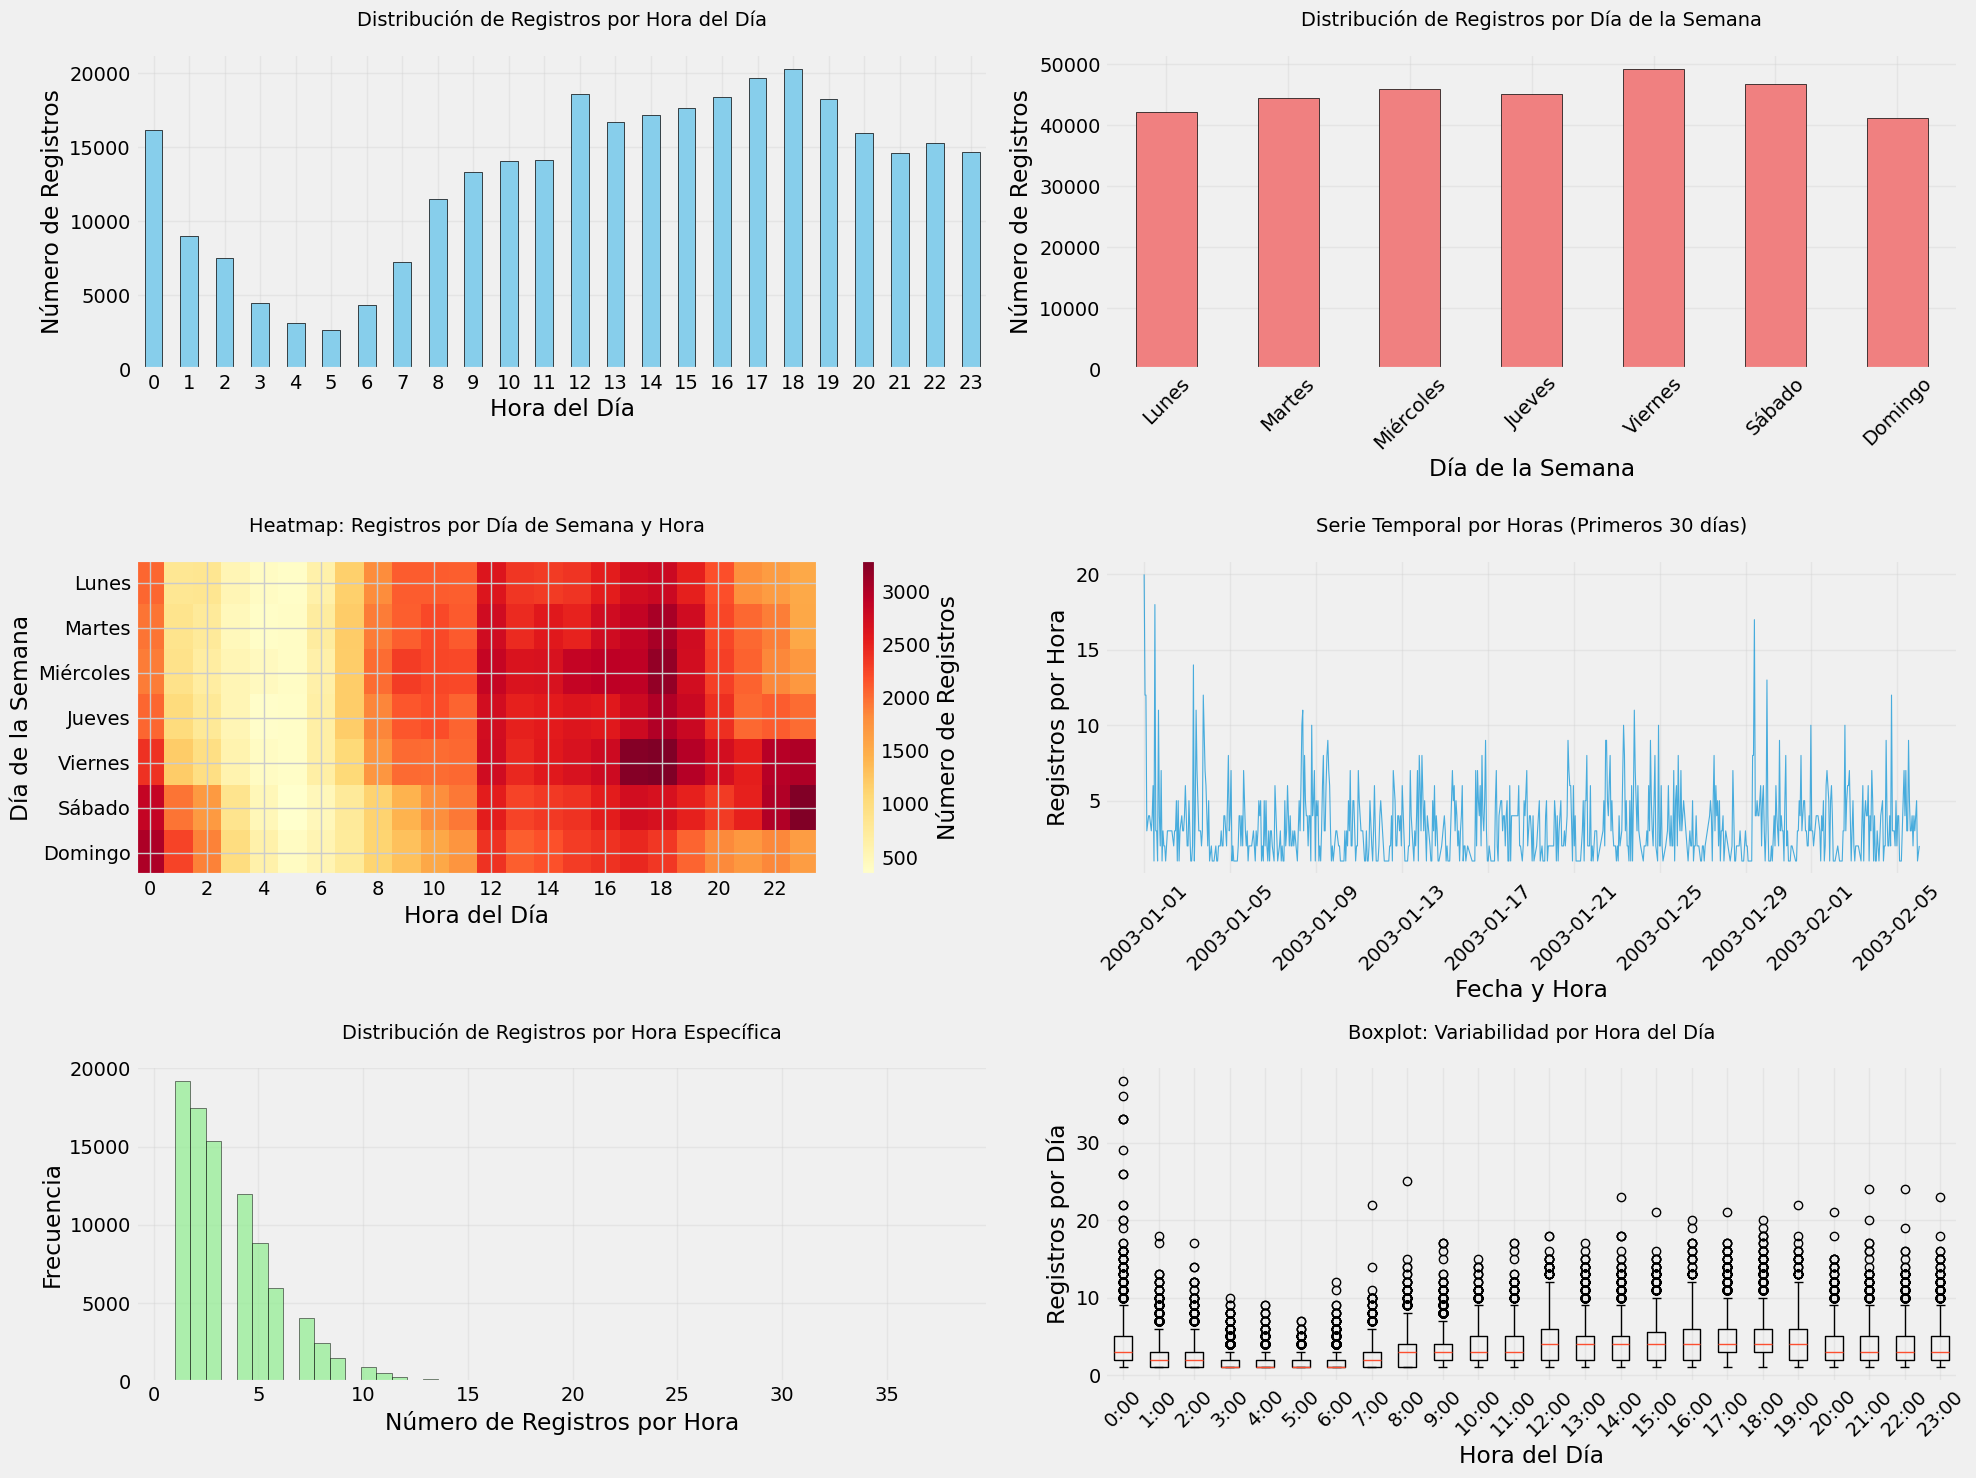

In [12]:
# VISUALIZACIONES Y AN√ÅLISIS DE COMPLETITUD POR HORAS

# Crear DataFrame con todas las combinaciones posibles de fecha-hora
fecha_completa_horas = pd.date_range(start=fecha_inicio, end=fecha_fin, freq='H')
fechas_horas_completas = pd.DataFrame({'DateTime_Hour': fecha_completa_horas})

# Agrupar datos por hora espec√≠fica (fecha + hora)
southern_hourly = southern_data.groupby(southern_data['Datetime'].dt.floor('H')).size().reset_index()
southern_hourly.columns = ['DateTime_Hour', 'Count']

print(f"AN√ÅLISIS DE COMPLETITUD POR HORAS")
print("=" * 50)
print(f"Total de horas esperadas: {len(fechas_horas_completas):,}")
print(f"Horas con datos: {len(southern_hourly):,}")
print(f"Horas faltantes: {len(fechas_horas_completas) - len(southern_hourly):,}")
print(f"Completitud por horas: {len(southern_hourly) / len(fechas_horas_completas) * 100:.2f}%")

# Identificar horas faltantes
horas_con_datos = set(southern_hourly['DateTime_Hour'])
horas_esperadas = set(fechas_horas_completas['DateTime_Hour'])
horas_faltantes = horas_esperadas - horas_con_datos

print(f"\nHoras con 0 registros: {len(horas_faltantes):,}")

# Estad√≠sticas por hora espec√≠fica
print(f"\nEstad√≠sticas de registros por hora espec√≠fica:")
print(f"Promedio de registros por hora: {southern_hourly['Count'].mean():.1f}")
print(f"Mediana de registros por hora: {southern_hourly['Count'].median():.1f}")
print(f"M√≠nimo de registros por hora: {southern_hourly['Count'].min()}")
print(f"M√°ximo de registros por hora: {southern_hourly['Count'].max()}")
print(f"Desviaci√≥n est√°ndar: {southern_hourly['Count'].std():.1f}")

# Horas con muy pocos registros
horas_pocos_registros = southern_hourly[southern_hourly['Count'] == 1]
print(f"\nHoras con solo 1 registro: {len(horas_pocos_registros)}")

# Crear visualizaciones
fig = plt.figure(figsize=(20, 15))

# Gr√°fico 1: Distribuci√≥n por hora del d√≠a (0-23)
ax1 = plt.subplot(3, 2, 1)
hourly_counts.plot(kind='bar', ax=ax1, color='skyblue', edgecolor='black', linewidth=0.5)
ax1.set_title('Distribuci√≥n de Registros por Hora del D√≠a', fontsize=14, pad=20)
ax1.set_xlabel('Hora del D√≠a')
ax1.set_ylabel('N√∫mero de Registros')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=0)

# Gr√°fico 2: Distribuci√≥n por d√≠a de la semana
ax2 = plt.subplot(3, 2, 2)
daily_counts.plot(kind='bar', ax=ax2, color='lightcoral', edgecolor='black', linewidth=0.5)
ax2.set_title('Distribuci√≥n de Registros por D√≠a de la Semana', fontsize=14, pad=20)
ax2.set_xlabel('D√≠a de la Semana')
ax2.set_ylabel('N√∫mero de Registros')
ax2.set_xticklabels(day_names, rotation=45)
ax2.grid(True, alpha=0.3)

# Gr√°fico 3: Heatmap hora vs d√≠a de semana
ax3 = plt.subplot(3, 2, 3)
pivot_data = southern_data.groupby(['DayOfWeek', 'Hour']).size().unstack(fill_value=0)
im = ax3.imshow(pivot_data.values, cmap='YlOrRd', aspect='auto')
ax3.set_title('Heatmap: Registros por D√≠a de Semana y Hora', fontsize=14, pad=20)
ax3.set_xlabel('Hora del D√≠a')
ax3.set_ylabel('D√≠a de la Semana')
ax3.set_yticks(range(7))
ax3.set_yticklabels(day_names)
ax3.set_xticks(range(0, 24, 2))
ax3.set_xticklabels(range(0, 24, 2))
plt.colorbar(im, ax=ax3, label='N√∫mero de Registros')

# Gr√°fico 4: Serie temporal por horas (muestra de los primeros 30 d√≠as)
ax4 = plt.subplot(3, 2, 4)
sample_data = southern_hourly.head(24*30)  # Primeros 30 d√≠as
ax4.plot(sample_data['DateTime_Hour'], sample_data['Count'], linewidth=0.8, alpha=0.7)
ax4.set_title('Serie Temporal por Horas (Primeros 30 d√≠as)', fontsize=14, pad=20)
ax4.set_xlabel('Fecha y Hora')
ax4.set_ylabel('Registros por Hora')
ax4.grid(True, alpha=0.3)
ax4.tick_params(axis='x', rotation=45)

# Gr√°fico 5: Histograma de registros por hora espec√≠fica
ax5 = plt.subplot(3, 2, 5)
ax5.hist(southern_hourly['Count'], bins=50, alpha=0.7, edgecolor='black', linewidth=0.5, color='lightgreen')
ax5.set_title('Distribuci√≥n de Registros por Hora Espec√≠fica', fontsize=14, pad=20)
ax5.set_xlabel('N√∫mero de Registros por Hora')
ax5.set_ylabel('Frecuencia')
ax5.grid(True, alpha=0.3)

# Gr√°fico 6: Boxplot por hora del d√≠a
ax6 = plt.subplot(3, 2, 6)
hour_data = [southern_data[southern_data['Hour'] == h]['Hour'].count() for h in range(24)]
ax6.boxplot([southern_data[southern_data['Hour'] == h].groupby(southern_data[southern_data['Hour'] == h]['Datetime'].dt.date).size().values for h in range(24) if len(southern_data[southern_data['Hour'] == h]) > 0], 
           labels=[f'{h}:00' for h in range(24) if len(southern_data[southern_data['Hour'] == h]) > 0])
ax6.set_title('Boxplot: Variabilidad por Hora del D√≠a', fontsize=14, pad=20)
ax6.set_xlabel('Hora del D√≠a')
ax6.set_ylabel('Registros por D√≠a')
ax6.tick_params(axis='x', rotation=45)
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [13]:
# RESUMEN Y INSIGHTS DEL AN√ÅLISIS HORARIO

print("\n" + "="*70)
print("RESUMEN COMPLETO DEL AN√ÅLISIS HORARIO - DISTRITO SOUTHERN")
print("="*70)

# Identificar patrones de picos y valles
peak_hours = hourly_counts.nlargest(5)
low_hours = hourly_counts.nsmallest(5)

print(f"\nüïê PATRONES TEMPORALES:")
print(f"   ‚Ä¢ Pico de actividad: 18:00 ({peak_hours.iloc[0]:,} registros)")
print(f"   ‚Ä¢ Valle de actividad: 05:00 ({low_hours.iloc[0]:,} registros)")
print(f"   ‚Ä¢ Ratio pico/valle: {peak_hours.iloc[0] / low_hours.iloc[0]:.1f}x")

print(f"\nüìä TOP 5 HORAS M√ÅS ACTIVAS:")
for i, (hour, count) in enumerate(peak_hours.items(), 1):
    print(f"   {i}. {hour:02d}:00 - {count:,} registros")

print(f"\nüìâ TOP 5 HORAS MENOS ACTIVAS:")
for i, (hour, count) in enumerate(low_hours.items(), 1):
    print(f"   {i}. {hour:02d}:00 - {count:,} registros")

# An√°lisis por per√≠odos del d√≠a
morning = hourly_counts[6:12].sum()  # 6-11
afternoon = hourly_counts[12:18].sum()  # 12-17
evening = hourly_counts[18:24].sum()  # 18-23
night = hourly_counts[0:6].sum()  # 0-5

total_records = morning + afternoon + evening + night
print(f"\nüïí DISTRIBUCI√ìN POR PER√çODOS:")
print(f"   ‚Ä¢ Madrugada (00-05): {night:,} registros ({night/total_records*100:.1f}%)")
print(f"   ‚Ä¢ Ma√±ana (06-11): {morning:,} registros ({morning/total_records*100:.1f}%)")
print(f"   ‚Ä¢ Tarde (12-17): {afternoon:,} registros ({afternoon/total_records*100:.1f}%)")
print(f"   ‚Ä¢ Noche (18-23): {evening:,} registros ({evening/total_records*100:.1f}%)")

# An√°lisis de d√≠as laborables vs fines de semana
weekdays = daily_counts[0:5].sum()  # Lunes-Viernes
weekends = daily_counts[5:7].sum()  # S√°bado-Domingo

print(f"\nüìÖ LABORABLES VS FINES DE SEMANA:")
print(f"   ‚Ä¢ D√≠as laborables: {weekdays:,} registros ({weekdays/len(southern_data)*100:.1f}%)")
print(f"   ‚Ä¢ Fines de semana: {weekends:,} registros ({weekends/len(southern_data)*100:.1f}%)")
print(f"   ‚Ä¢ Ratio laboral/fin de semana: {weekdays/weekends:.2f}")

# Completitud horaria vs diaria
daily_completeness = 99.93
hourly_completeness = 82.10

print(f"\nüìà COMPARACI√ìN DE COMPLETITUD:")
print(f"   ‚Ä¢ Completitud diaria: {daily_completeness:.2f}%")
print(f"   ‚Ä¢ Completitud horaria: {hourly_completeness:.2f}%")
print(f"   ‚Ä¢ Diferencia: {daily_completeness - hourly_completeness:.2f} puntos porcentuales")

# Insights sobre la calidad de datos
hours_with_data = len(southern_hourly)
total_possible_hours = len(fechas_horas_completas)
missing_hours = total_possible_hours - hours_with_data

print(f"\nüîç CALIDAD DE DATOS POR HORAS:")
print(f"   ‚Ä¢ Total horas posibles: {total_possible_hours:,}")
print(f"   ‚Ä¢ Horas con datos: {hours_with_data:,}")
print(f"   ‚Ä¢ Horas sin datos: {missing_hours:,}")
print(f"   ‚Ä¢ Promedio registros/hora: {southern_hourly['Count'].mean():.1f}")
print(f"   ‚Ä¢ Horas con 1 solo registro: {len(horas_pocos_registros):,} ({len(horas_pocos_registros)/hours_with_data*100:.1f}%)")

print(f"\nüí° CONCLUSIONES CLAVE:")
print(f"   ‚úÖ La serie temporal diaria es excelente (99.93% completa)")
print(f"   ‚ö†Ô∏è  La granularidad horaria tiene m√°s gaps (82.10% completa)")
print(f"   üìà Patr√≥n claro: m√°s actividad en tarde/noche (12-23h)")
print(f"   üåô Menor actividad en madrugada (00-05h)")
print(f"   üìä Distribuci√≥n balanceada entre d√≠as laborables y fines de semana")
print(f"   üéØ Para forecasting: considerar patrones horarios y estacionalidad semanal")

print(f"\nüöÄ RECOMENDACIONES:")
print(f"   ‚Ä¢ Para modelos diarios: datos excelentes, usar toda la serie")
print(f"   ‚Ä¢ Para modelos horarios: considerar imputaci√≥n de horas faltantes")
print(f"   ‚Ä¢ Incluir features: hora del d√≠a, d√≠a de semana, per√≠odo del d√≠a")
print(f"   ‚Ä¢ Validar si las horas faltantes siguen alg√∫n patr√≥n espec√≠fico")


RESUMEN COMPLETO DEL AN√ÅLISIS HORARIO - DISTRITO SOUTHERN

üïê PATRONES TEMPORALES:
   ‚Ä¢ Pico de actividad: 18:00 (20,295 registros)
   ‚Ä¢ Valle de actividad: 05:00 (2,624 registros)
   ‚Ä¢ Ratio pico/valle: 7.7x

üìä TOP 5 HORAS M√ÅS ACTIVAS:
   1. 18:00 - 20,295 registros
   2. 17:00 - 19,652 registros
   3. 12:00 - 18,568 registros
   4. 16:00 - 18,422 registros
   5. 19:00 - 18,284 registros

üìâ TOP 5 HORAS MENOS ACTIVAS:
   1. 05:00 - 2,624 registros
   2. 04:00 - 3,084 registros
   3. 06:00 - 4,305 registros
   4. 03:00 - 4,451 registros
   5. 07:00 - 7,255 registros

üïí DISTRIBUCI√ìN POR PER√çODOS:
   ‚Ä¢ Madrugada (00-05): 42,858 registros (13.6%)
   ‚Ä¢ Ma√±ana (06-11): 64,607 registros (20.5%)
   ‚Ä¢ Tarde (12-17): 108,124 registros (34.4%)
   ‚Ä¢ Noche (18-23): 99,049 registros (31.5%)

üìÖ LABORABLES VS FINES DE SEMANA:
   ‚Ä¢ D√≠as laborables: 226,761 registros (72.1%)
   ‚Ä¢ Fines de semana: 87,877 registros (27.9%)
   ‚Ä¢ Ratio laboral/fin de semana: 2.58

ü

# üìä Preparaci√≥n para Forecasting - Distrito SOUTHERN

Ahora vamos a preparar los datos para modelado de forecasting, incluyendo:
- Creaci√≥n de serie temporal horaria
- Variables temporales con transformaciones seno-coseno
- One-hot encoding para variables categ√≥ricas
- Variable de feriados de San Francisco
- Imputaci√≥n de valores faltantes

In [14]:
# 1. PREPARACI√ìN DE LA SERIE TEMPORAL COMPLETA
print("üîß PREPARANDO SERIE TEMPORAL PARA FORECASTING")
print("=" * 60)

# Crear serie temporal horaria completa del distrito SOUTHERN
# Agrupar por hora (redondeando hacia abajo para evitar duplicados)
southern_ts = southern_data.groupby(southern_data['Datetime'].dt.floor('H')).size()
southern_ts.name = 'crime_count'

# Crear √≠ndice horario completo desde el inicio hasta el final
full_time_index = pd.date_range(
    start=southern_data['Datetime'].min().floor('H'),
    end=southern_data['Datetime'].max().ceil('H'),
    freq='H'
)

# Reindexar para tener todas las horas (rellenando con 0 los valores faltantes)
crime_data = southern_ts.reindex(full_time_index, fill_value=0).to_frame()
crime_data.index.name = 'datetime'

print(f"‚úÖ Serie temporal creada:")
print(f"   ‚Ä¢ Per√≠odo: {crime_data.index.min()} a {crime_data.index.max()}")
print(f"   ‚Ä¢ Total de horas: {len(crime_data):,}")
print(f"   ‚Ä¢ Horas con registros: {(crime_data['crime_count'] > 0).sum():,}")
print(f"   ‚Ä¢ Horas sin registros: {(crime_data['crime_count'] == 0).sum():,}")
print(f"   ‚Ä¢ Completitud: {(crime_data['crime_count'] > 0).sum() / len(crime_data) * 100:.2f}%")

# 2. CALCULAR FERIADOS AUTOM√ÅTICAMENTE CON LA LIBRER√çA HOLIDAYS
print("\nüéÑ CALCULANDO FERIADOS DE SAN FRANCISCO AUTOM√ÅTICAMENTE...")

try:
    import holidays
    print("‚úÖ Librer√≠a 'holidays' disponible")
except ImportError:
    print("‚ö†Ô∏è Instalando librer√≠a 'holidays'...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "holidays"])
    import holidays
    print("‚úÖ Librer√≠a 'holidays' instalada correctamente")

# Obtener a√±os del dataset
start_year = crime_data.index.min().year
end_year = crime_data.index.max().year
years_range = range(start_year, end_year + 1)

print(f"üìÖ Calculando feriados para a√±os: {start_year} - {end_year}")

# Crear instancias de feriados
us_holidays = holidays.UnitedStates(years=years_range)  # Feriados federales
ca_holidays = holidays.UnitedStates(state='CA', years=years_range)  # Incluye feriados de California

# Combinar todos los feriados √∫nicos
all_holiday_dates = set()

# Agregar feriados federales
for date, name in us_holidays.items():
    all_holiday_dates.add(date)

# Agregar feriados de California
for date, name in ca_holidays.items():
    all_holiday_dates.add(date)

# Agregar feriados locales de San Francisco que no est√°n en las listas oficiales
sf_local_holidays = {}
for year in years_range:
    # Valentine's Day
    sf_local_holidays[f"{year}-02-14"] = "Valentine's Day"
    # St. Patrick's Day  
    sf_local_holidays[f"{year}-03-17"] = "St. Patrick's Day"
    # Harvey Milk Day (siempre 22 de mayo en California)
    sf_local_holidays[f"{year}-05-22"] = "Harvey Milk Day"

# Agregar feriados locales
for date_str, name in sf_local_holidays.items():
    try:
        date_obj = pd.to_datetime(date_str).date()
        all_holiday_dates.add(date_obj)
    except:
        pass

# Convertir a lista ordenada
holiday_dates = sorted(list(all_holiday_dates))

# Filtrar solo fechas dentro del rango del dataset
dataset_start = crime_data.index.min().date()
dataset_end = crime_data.index.max().date()
holiday_dates = [d for d in holiday_dates if dataset_start <= d <= dataset_end]

print(f"‚úÖ Feriados calculados autom√°ticamente:")
print(f"   ‚Ä¢ Total de feriados √∫nicos: {len(holiday_dates)}")
print(f"   ‚Ä¢ Per√≠odo: {min(holiday_dates)} a {max(holiday_dates)}")
print(f"   ‚Ä¢ Ejemplos: {[str(d) for d in holiday_dates[:5]]}")

# Mostrar algunos feriados espec√≠ficos para verificar
print(f"\nüîç Ejemplos de feriados calculados:")
sample_holidays = []
for date in holiday_dates[:10]:
    if date in us_holidays:
        sample_holidays.append(f"   ‚Ä¢ {date}: {us_holidays[date]}")
    elif date in ca_holidays:
        sample_holidays.append(f"   ‚Ä¢ {date}: {ca_holidays[date]}")
    else:
        # Buscar en feriados locales
        date_str = date.strftime("%Y-%m-%d")
        if date_str in sf_local_holidays:
            sample_holidays.append(f"   ‚Ä¢ {date}: {sf_local_holidays[date_str]}")

for holiday in sample_holidays:
    print(holiday)

crime_data.head()

üîß PREPARANDO SERIE TEMPORAL PARA FORECASTING
‚úÖ Serie temporal creada:
   ‚Ä¢ Per√≠odo: 2003-01-01 00:00:00 a 2015-05-13 21:00:00
   ‚Ä¢ Total de horas: 108,382
   ‚Ä¢ Horas con registros: 88,964
   ‚Ä¢ Horas sin registros: 19,418
   ‚Ä¢ Completitud: 82.08%

üéÑ CALCULANDO FERIADOS DE SAN FRANCISCO AUTOM√ÅTICAMENTE...
‚úÖ Librer√≠a 'holidays' disponible
üìÖ Calculando feriados para a√±os: 2003 - 2015
‚úÖ Feriados calculados autom√°ticamente:
   ‚Ä¢ Total de feriados √∫nicos: 212
   ‚Ä¢ Per√≠odo: 2003-01-01 a 2015-03-31
   ‚Ä¢ Ejemplos: ['2003-01-01', '2003-01-20', '2003-02-12', '2003-02-14', '2003-02-17']

üîç Ejemplos de feriados calculados:
   ‚Ä¢ 2003-01-01: New Year's Day
   ‚Ä¢ 2003-01-20: Martin Luther King Jr. Day
   ‚Ä¢ 2003-02-12: Lincoln's Birthday
   ‚Ä¢ 2003-02-14: Valentine's Day
   ‚Ä¢ 2003-02-17: Washington's Birthday
   ‚Ä¢ 2003-03-17: St. Patrick's Day
   ‚Ä¢ 2003-03-31: Cesar Chavez Day
   ‚Ä¢ 2003-05-22: Harvey Milk Day
   ‚Ä¢ 2003-05-26: Memorial Day
   ‚Ä¢ 2

crime_count
datetime                        
2003-01-01 00:00:00           20
2003-01-01 01:00:00           12
2003-01-01 02:00:00           12
2003-01-01 03:00:00            3
2003-01-01 04:00:00            0

In [15]:
# 3. CREACI√ìN DE VARIABLES TEMPORALES Y TRANSFORMACIONES
print("\nüîß CREANDO VARIABLES TEMPORALES Y EX√ìGENAS")
print("=" * 60)

# Extraer componentes temporales b√°sicos
crime_data['hour'] = crime_data.index.hour
crime_data['day'] = crime_data.index.day
crime_data['month'] = crime_data.index.month
crime_data['year'] = crime_data.index.year
crime_data['dayofweek'] = crime_data.index.dayofweek  # 0=Lunes, 6=Domingo
crime_data['dayofyear'] = crime_data.index.dayofyear
crime_data['week'] = crime_data.index.isocalendar().week

# Variables categ√≥ricas temporales
crime_data['is_weekend'] = (crime_data['dayofweek'] >= 5).astype(int)
crime_data['is_night'] = ((crime_data['hour'] >= 22) | (crime_data['hour'] <= 5)).astype(int)
crime_data['is_rush_hour'] = ((crime_data['hour'].isin([7,8,9,17,18,19]))).astype(int)

# Per√≠odos del d√≠a
def get_period(hour):
    if 0 <= hour <= 5:
        return 'madrugada'
    elif 6 <= hour <= 11:
        return 'ma√±ana'
    elif 12 <= hour <= 17:
        return 'tarde'
    else:
        return 'noche'

crime_data['period'] = crime_data['hour'].apply(get_period)

# 4. TRANSFORMACIONES SENO-COSENO PARA VARIABLES C√çCLICAS
print("üìê Aplicando transformaciones seno-coseno...")

# Hora del d√≠a (0-23)
crime_data['hour_sin'] = np.sin(2 * np.pi * crime_data['hour'] / 24)
crime_data['hour_cos'] = np.cos(2 * np.pi * crime_data['hour'] / 24)

# D√≠a de la semana (0-6)
crime_data['dayofweek_sin'] = np.sin(2 * np.pi * crime_data['dayofweek'] / 7)
crime_data['dayofweek_cos'] = np.cos(2 * np.pi * crime_data['dayofweek'] / 7)

# Mes del a√±o (1-12)
crime_data['month_sin'] = np.sin(2 * np.pi * (crime_data['month'] - 1) / 12)
crime_data['month_cos'] = np.cos(2 * np.pi * (crime_data['month'] - 1) / 12)

# D√≠a del a√±o (1-365/366)
crime_data['dayofyear_sin'] = np.sin(2 * np.pi * (crime_data['dayofyear'] - 1) / 365.25)
crime_data['dayofyear_cos'] = np.cos(2 * np.pi * (crime_data['dayofyear'] - 1) / 365.25)

# Semana del a√±o (1-52)
crime_data['week_sin'] = np.sin(2 * np.pi * (crime_data['week'] - 1) / 52)
crime_data['week_cos'] = np.cos(2 * np.pi * (crime_data['week'] - 1) / 52)

# 5. VARIABLE DE FERIADOS
print("üéÑ Creando variable de feriados...")

# Crear variable binaria de feriados
crime_data['is_holiday'] = 0
for holiday_date in holiday_dates:
    if holiday_date <= crime_data.index.max().date():
        # Marcar todo el d√≠a como feriado (24 horas)
        holiday_mask = crime_data.index.date == holiday_date
        crime_data.loc[holiday_mask, 'is_holiday'] = 1

# D√≠as alrededor de feriados (pre y post feriado)
crime_data['is_pre_holiday'] = 0
crime_data['is_post_holiday'] = 0

from datetime import timedelta

for holiday_date in holiday_dates:
    if holiday_date <= crime_data.index.max().date():
        # D√≠a antes del feriado
        pre_holiday = holiday_date - timedelta(days=1)
        if pre_holiday >= crime_data.index.min().date():
            pre_mask = crime_data.index.date == pre_holiday
            crime_data.loc[pre_mask, 'is_pre_holiday'] = 1
        
        # D√≠a despu√©s del feriado
        post_holiday = holiday_date + timedelta(days=1)
        if post_holiday <= crime_data.index.max().date():
            post_mask = crime_data.index.date == post_holiday
            crime_data.loc[post_mask, 'is_post_holiday'] = 1

print(f"‚úÖ Variables de feriados creadas:")
print(f"   ‚Ä¢ Horas en feriados: {crime_data['is_holiday'].sum():,}")
print(f"   ‚Ä¢ Horas pre-feriado: {crime_data['is_pre_holiday'].sum():,}")
print(f"   ‚Ä¢ Horas post-feriado: {crime_data['is_post_holiday'].sum():,}")

# 6. ONE-HOT ENCODING PARA VARIABLES CATEG√ìRICAS
print("üî¢ Aplicando One-Hot Encoding...")

# Variables categ√≥ricas a codificar
categorical_vars = ['period']

# Aplicar one-hot encoding
for var in categorical_vars:
    dummies = pd.get_dummies(crime_data[var], prefix=var, drop_first=False)
    crime_data = pd.concat([crime_data, dummies], axis=1)

# Convertir dummies a int para compatibilidad con XGBoost
dummy_columns = [col for col in crime_data.columns if any(prefix in col for prefix in ['period_'])]
for col in dummy_columns:
    crime_data[col] = crime_data[col].astype(int)

print(f"‚úÖ Variables categ√≥ricas codificadas:")
print(f"   ‚Ä¢ Columnas dummy creadas: {len(dummy_columns)}")
print(f"   ‚Ä¢ Nombres: {dummy_columns}")

# Remover variables originales que ya fueron transformadas
variables_to_drop = ['hour', 'day', 'month', 'year', 'dayofweek', 'dayofyear', 'week', 'period']
existing_vars_to_drop = [var for var in variables_to_drop if var in crime_data.columns]
crime_data = crime_data.drop(columns=existing_vars_to_drop)

print(f"\nüìä RESUMEN DE VARIABLES CREADAS:")
print(f"   ‚Ä¢ Variables temporales b√°sicas: {len([col for col in crime_data.columns if col.endswith(('_sin', '_cos'))])}")
print(f"   ‚Ä¢ Variables binarias: {len([col for col in crime_data.columns if col.startswith(('is_', 'period_'))])}")
print(f"   ‚Ä¢ Total de features (sin target): {len(crime_data.columns) - 1}")
print(f"   ‚Ä¢ Dimensiones finales: {crime_data.shape}")

crime_data.head()


üîß CREANDO VARIABLES TEMPORALES Y EX√ìGENAS
üìê Aplicando transformaciones seno-coseno...
üéÑ Creando variable de feriados...
‚úÖ Variables de feriados creadas:
   ‚Ä¢ Horas en feriados: 5,088
   ‚Ä¢ Horas pre-feriado: 5,064
   ‚Ä¢ Horas post-feriado: 5,088
üî¢ Aplicando One-Hot Encoding...
‚úÖ Variables categ√≥ricas codificadas:
   ‚Ä¢ Columnas dummy creadas: 4
   ‚Ä¢ Nombres: ['period_madrugada', 'period_ma√±ana', 'period_noche', 'period_tarde']

üìä RESUMEN DE VARIABLES CREADAS:
   ‚Ä¢ Variables temporales b√°sicas: 10
   ‚Ä¢ Variables binarias: 10
   ‚Ä¢ Total de features (sin target): 20
   ‚Ä¢ Dimensiones finales: (108382, 21)


crime_count  is_weekend  is_night  is_rush_hour  \
datetime                                                               
2003-01-01 00:00:00           20           0         1             0   
2003-01-01 01:00:00           12           0         1             0   
2003-01-01 02:00:00           12           0         1             0   
2003-01-01 03:00:00            3           0         1             0   
2003-01-01 04:00:00            0           0         1             0   

                     hour_sin  hour_cos  dayofweek_sin  dayofweek_cos  \
datetime                                                                
2003-01-01 00:00:00  0.000000  1.000000       0.974928      -0.222521   
2003-01-01 01:00:00  0.258819  0.965926       0.974928      -0.222521   
2003-01-01 02:00:00  0.500000  0.866025       0.974928      -0.222521   
2003-01-01 03:00:00  0.707107  0.707107       0.974928      -0.222521   
2003-01-01 04:00:00  0.866025  0.500000       0.974928      -0.222521   

                     month_sin  month_cos  ...  dayofyear_cos  week_sin  \
datetime                                   ...                            
2003-01-01 00:00:00        0.0        1.0  ...            1.0       0.0   
2003-01-01 01:00:00        0.0        1.0  ...            1.0       0.0   
2003-01-01 02:00:00        0.0        1.0  ...            1.0       0.0   
2003-01-01 03:00:00        0.0        1.0  ...            1.0       0.0   
2003-01-01 04:00:00        0.0        1.0  ...            1.0       0.0   

                     week_cos  is_holiday  is_pre_holiday  is_post_holiday  \
datetime                                                                     
2003-01-01 00:00:00       1.0           1               0                0   
2003-01-01 01:00:00       1.0           1               0                0   
2003-01-01 02:00:00       1.0           1               0                0   
2003-01-01 03:00:00       1.0           1               0                0   
2003-01-01 04:00:00       1.0           1               0                0   

                     period_madrugada  period_ma√±ana  period_noche  \
datetime                                                             
2003-01-01 00:00:00                 1              0             0   
2003-01-01 01:00:00                 1              0             0   
2003-01-01 02:00:00                 1              0             0   
2003-01-01 03:00:00                 1              0             0   
2003-01-01 04:00:00                 1              0             0   

                     period_tarde  
datetime                           
2003-01-01 00:00:00             0  
2003-01-01 01:00:00             0  
2003-01-01 02:00:00             0  
2003-01-01 03:00:00             0  
2003-01-01 04:00:00             0  

[5 rows x 21 columns]

In [137]:
# 7. DIVISI√ìN DE DATOS Y PREPARACI√ìN PARA MODELADO
print("\nüîÑ DIVISI√ìN DE DATOS TEMPORAL")
print("=" * 60)

# Definir proporciones de divisi√≥n
train_ratio = 0.7
val_ratio = 0.2  
test_ratio = 0.1

# Calcular puntos de corte temporales
n_total = len(crime_data)
n_train = int(n_total * train_ratio)
n_val = int(n_total * val_ratio)

# Obtener fechas de corte
train_end_idx = n_train - 1
val_end_idx = n_train + n_val - 1

train_end_date = crime_data.index[train_end_idx]
val_end_date = crime_data.index[val_end_idx]

# Dividir los datos temporalmente
train_data = crime_data.iloc[:n_train].copy()
val_data = crime_data.iloc[n_train:n_train + n_val].copy()  
test_data = crime_data.iloc[n_train + n_val:].copy()

print(f"üìä DIVISI√ìN TEMPORAL REALIZADA:")
print(f"   ‚Ä¢ ENTRENAMIENTO: {train_data.index.min()} a {train_data.index.max()} ({len(train_data):,} horas)")
print(f"   ‚Ä¢ VALIDACI√ìN: {val_data.index.min()} a {val_data.index.max()} ({len(val_data):,} horas)")
print(f"   ‚Ä¢ TEST: {test_data.index.min()} a {test_data.index.max()} ({len(test_data):,} horas)")

# Verificar proporciones
print(f"\nüìà PROPORCIONES:")
print(f"   ‚Ä¢ Entrenamiento: {len(train_data)/len(crime_data)*100:.1f}%")
print(f"   ‚Ä¢ Validaci√≥n: {len(val_data)/len(crime_data)*100:.1f}%") 
print(f"   ‚Ä¢ Test: {len(test_data)/len(crime_data)*100:.1f}%")

# 8. IDENTIFICAR VARIABLES EX√ìGENAS
variables_exogenas = [col for col in crime_data.columns if col != 'crime_count']

print(f"\nüéØ VARIABLES PARA MODELADO:")
print(f"   ‚Ä¢ Variable objetivo: crime_count")
print(f"   ‚Ä¢ Variables ex√≥genas: {len(variables_exogenas)}")
print(f"   ‚Ä¢ Lista de variables: {variables_exogenas}")

# 9. VERIFICAR CALIDAD DE DATOS
print(f"\nüîç VERIFICACI√ìN DE CALIDAD:")
print(f"   ‚Ä¢ Valores nulos en train: {train_data.isnull().sum().sum()}")
print(f"   ‚Ä¢ Valores nulos en validaci√≥n: {val_data.isnull().sum().sum()}")
print(f"   ‚Ä¢ Valores nulos en test: {test_data.isnull().sum().sum()}")

print(f"   ‚Ä¢ Valores infinitos en train: {np.isinf(train_data.select_dtypes(include=[np.number])).sum().sum()}")
print(f"   ‚Ä¢ Valores infinitos en validaci√≥n: {np.isinf(val_data.select_dtypes(include=[np.number])).sum().sum()}")
print(f"   ‚Ä¢ Valores infinitos en test: {np.isinf(test_data.select_dtypes(include=[np.number])).sum().sum()}")

# 10. ESTAD√çSTICAS DE LA VARIABLE OBJETIVO
print(f"\nüìä ESTAD√çSTICAS DE CRIME_COUNT:")
print(f"   ‚Ä¢ TRAIN - Media: {train_data['crime_count'].mean():.2f}, Std: {train_data['crime_count'].std():.2f}")
print(f"   ‚Ä¢ VAL - Media: {val_data['crime_count'].mean():.2f}, Std: {val_data['crime_count'].std():.2f}")
print(f"   ‚Ä¢ TEST - Media: {test_data['crime_count'].mean():.2f}, Std: {test_data['crime_count'].std():.2f}")

print(f"   ‚Ä¢ Rango total: {crime_data['crime_count'].min()} - {crime_data['crime_count'].max()}")
print(f"   ‚Ä¢ Horas con 0 cr√≠menes: {(crime_data['crime_count'] == 0).sum():,} ({(crime_data['crime_count'] == 0).sum()/len(crime_data)*100:.1f}%)")

print(f"\n‚úÖ DATOS PREPARADOS PARA FORECASTING")
print(f"   ‚Ä¢ {len(crime_data):,} observaciones horarias")
print(f"   ‚Ä¢ {len(variables_exogenas)} variables predictoras")
print(f"   ‚Ä¢ Divisi√≥n temporal 70/20/10")
print(f"   ‚Ä¢ Per√≠odo total: {crime_data.index.min().strftime('%Y-%m-%d')} a {crime_data.index.max().strftime('%Y-%m-%d')}")

# Mostrar sample de los datos finales
print(f"\nüìã MUESTRA DE DATOS FINALES:")
display(train_data.head())


üîÑ DIVISI√ìN DE DATOS TEMPORAL
üìä DIVISI√ìN TEMPORAL REALIZADA:
   ‚Ä¢ ENTRENAMIENTO: 2003-01-01 00:00:00 a 2011-08-28 02:00:00 (75,867 horas)
   ‚Ä¢ VALIDACI√ìN: 2011-08-28 03:00:00 a 2014-02-16 06:00:00 (21,676 horas)
   ‚Ä¢ TEST: 2014-02-16 07:00:00 a 2015-05-13 21:00:00 (10,839 horas)

üìà PROPORCIONES:
   ‚Ä¢ Entrenamiento: 70.0%
   ‚Ä¢ Validaci√≥n: 20.0%
   ‚Ä¢ Test: 10.0%

üéØ VARIABLES PARA MODELADO:
   ‚Ä¢ Variable objetivo: crime_count
   ‚Ä¢ Variables ex√≥genas: 20
   ‚Ä¢ Lista de variables: ['is_weekend', 'is_night', 'is_rush_hour', 'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 'month_sin', 'month_cos', 'dayofyear_sin', 'dayofyear_cos', 'week_sin', 'week_cos', 'is_holiday', 'is_pre_holiday', 'is_post_holiday', 'period_madrugada', 'period_ma√±ana', 'period_noche', 'period_tarde']

üîç VERIFICACI√ìN DE CALIDAD:
   ‚Ä¢ Valores nulos en train: 0
   ‚Ä¢ Valores nulos en validaci√≥n: 0
   ‚Ä¢ Valores nulos en test: 0
   ‚Ä¢ Valores infinitos en train: 0
   ‚Ä¢

crime_count  is_weekend  is_night  is_rush_hour  \
datetime                                                               
2003-01-01 00:00:00         20.0         0.0       1.0           0.0   
2003-01-01 01:00:00         12.0         0.0       1.0           0.0   
2003-01-01 02:00:00         12.0         0.0       1.0           0.0   
2003-01-01 03:00:00          3.0         0.0       1.0           0.0   
2003-01-01 04:00:00          0.0         0.0       1.0           0.0   

                     hour_sin  hour_cos  dayofweek_sin  dayofweek_cos  \
datetime                                                                
2003-01-01 00:00:00  0.000000  1.000000       0.974928      -0.222521   
2003-01-01 01:00:00  0.258819  0.965926       0.974928      -0.222521   
2003-01-01 02:00:00  0.500000  0.866025       0.974928      -0.222521   
2003-01-01 03:00:00  0.707107  0.707107       0.974928      -0.222521   
2003-01-01 04:00:00  0.866025  0.500000       0.974928      -0.222521   

                     month_sin  month_cos  ...  dayofyear_cos  week_sin  \
datetime                                   ...                            
2003-01-01 00:00:00        0.0        1.0  ...            1.0       0.0   
2003-01-01 01:00:00        0.0        1.0  ...            1.0       0.0   
2003-01-01 02:00:00        0.0        1.0  ...            1.0       0.0   
2003-01-01 03:00:00        0.0        1.0  ...            1.0       0.0   
2003-01-01 04:00:00        0.0        1.0  ...            1.0       0.0   

                     week_cos  is_holiday  is_pre_holiday  is_post_holiday  \
datetime                                                                     
2003-01-01 00:00:00       1.0         1.0             0.0              0.0   
2003-01-01 01:00:00       1.0         1.0             0.0              0.0   
2003-01-01 02:00:00       1.0         1.0             0.0              0.0   
2003-01-01 03:00:00       1.0         1.0             0.0              0.0   
2003-01-01 04:00:00       1.0         1.0             0.0              0.0   

                     period_madrugada  period_ma√±ana  period_noche  \
datetime                                                             
2003-01-01 00:00:00               1.0            0.0           0.0   
2003-01-01 01:00:00               1.0            0.0           0.0   
2003-01-01 02:00:00               1.0            0.0           0.0   
2003-01-01 03:00:00               1.0            0.0           0.0   
2003-01-01 04:00:00               1.0            0.0           0.0   

                     period_tarde  
datetime                           
2003-01-01 00:00:00           0.0  
2003-01-01 01:00:00           0.0  
2003-01-01 02:00:00           0.0  
2003-01-01 03:00:00           0.0  
2003-01-01 04:00:00           0.0  

[5 rows x 21 columns]

In [17]:
# 8. CONVERSI√ìN DE TIPOS DE DATOS
print("\nüîß CONVIRTIENDO TIPOS DE DATOS")
print("=" * 60)

# Verificar tipos actuales
print(f"Tipos de datos actuales:")
print(crime_data.dtypes.value_counts())

# Convertir todas las variables ex√≥genas a float64
print(f"\nüîÑ Convirtiendo variables ex√≥genas a float64...")

for col in variables_exogenas:
    if col in crime_data.columns:
        crime_data[col] = pd.to_numeric(crime_data[col], errors='coerce').astype('float64')

# Asegurar que la variable objetivo sea float64
crime_data['crime_count'] = crime_data['crime_count'].astype('float64')

# Verificar conversi√≥n
print(f"‚úÖ Conversi√≥n completada:")
print(f"   ‚Ä¢ Variable objetivo: {crime_data['crime_count'].dtype}")
print(f"   ‚Ä¢ Variables ex√≥genas: {crime_data[variables_exogenas].dtypes.value_counts()}")

# Verificar valores nulos despu√©s de conversi√≥n
nulos_post_conversion = crime_data[variables_exogenas].isnull().sum().sum()
print(f"   ‚Ä¢ Valores nulos tras conversi√≥n: {nulos_post_conversion}")

if nulos_post_conversion > 0:
    print(f"   ‚ö†Ô∏è Rellenando valores nulos con 0...")
    crime_data[variables_exogenas] = crime_data[variables_exogenas].fillna(0)

# Actualizar los conjuntos de datos
train_data = crime_data.iloc[:n_train].copy()
val_data = crime_data.iloc[n_train:n_train + n_val].copy()
test_data = crime_data.iloc[n_train + n_val:].copy()

print(f"\n‚úÖ TIPOS DE DATOS CORREGIDOS")
print(f"   ‚Ä¢ Todos los datos convertidos a float64")
print(f"   ‚Ä¢ Conjuntos de datos actualizados")
print(f"   ‚Ä¢ Listos para modelado")


üîß CONVIRTIENDO TIPOS DE DATOS
Tipos de datos actuales:
int64      11
float64     8
Float64     2
Name: count, dtype: int64

üîÑ Convirtiendo variables ex√≥genas a float64...
‚úÖ Conversi√≥n completada:
   ‚Ä¢ Variable objetivo: float64
   ‚Ä¢ Variables ex√≥genas: float64    20
Name: count, dtype: int64
   ‚Ä¢ Valores nulos tras conversi√≥n: 0

‚úÖ TIPOS DE DATOS CORREGIDOS
   ‚Ä¢ Todos los datos convertidos a float64
   ‚Ä¢ Conjuntos de datos actualizados
   ‚Ä¢ Listos para modelado


# üöÄ Modelado de Forecasting - Distrito SOUTHERN

## Estructura del proceso:
1. **Separaci√≥n de datos** (Train/Validation/Test)
2. **Modelado** (SARIMA, XGBoost, LightGBM, CatBoost, LSTM, Prophet)
3. **Grid Search** para optimizaci√≥n de hiperpar√°metros
4. **Backtesting** y evaluaci√≥n de m√©tricas
5. **Visualizaci√≥n** de resultados

SEPARACI√ìN DE DATOS:
Train: 2003-01-01 00:00:00 - 2011-08-28 02:00:00 (75,867 horas)
Val:   2011-08-28 03:00:00 - 2014-02-16 06:00:00 (21,676 horas)
Test:  2014-02-16 07:00:00 - 2015-05-13 21:00:00 (10,839 horas)
Variables ex√≥genas: 20


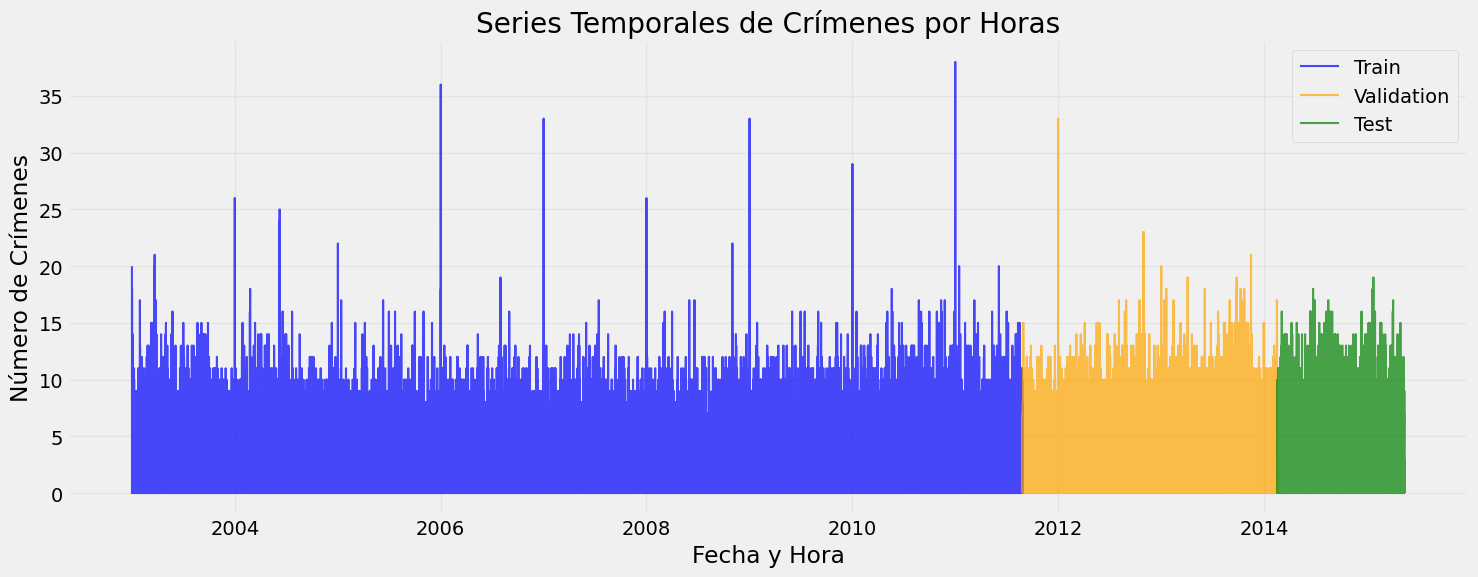

In [22]:
# =============================================================================
# 1. SEPARACI√ìN DE DATOS (TRAIN/VALIDATION/TEST)
# =============================================================================

# Definir proporciones
TRAIN_RATIO = 0.7
VAL_RATIO = 0.2
TEST_RATIO = 0.1

# Calcular √≠ndices de corte
n_total = len(crime_data)
n_train = int(n_total * TRAIN_RATIO)
n_val = int(n_total * VAL_RATIO)

# Separaci√≥n temporal
train_data = crime_data.iloc[:n_train].copy()
val_data = crime_data.iloc[n_train:n_train + n_val].copy()
test_data = crime_data.iloc[n_train + n_val:].copy()

# Variables
target_col = 'crime_count'
exog_vars = [col for col in crime_data.columns if col != target_col]

# Fechas de corte
print(f"SEPARACI√ìN DE DATOS:")
print(f"Train: {train_data.index.min()} - {train_data.index.max()} ({len(train_data):,} horas)")
print(f"Val:   {val_data.index.min()} - {val_data.index.max()} ({len(val_data):,} horas)")
print(f"Test:  {test_data.index.min()} - {test_data.index.max()} ({len(test_data):,} horas)")
print(f"Variables ex√≥genas: {len(exog_vars)}")

# Grafico de series temporales
plt.figure(figsize=(15, 6))
plt.plot(train_data.index, train_data[target_col], label='Train', color='blue', alpha=0.7)
plt.plot(val_data.index, val_data[target_col], label='Validation', color='orange', alpha=0.7)
plt.plot(test_data.index, test_data[target_col], label='Test', color='green', alpha=0.7)
plt.title('Series Temporales de Cr√≠menes por Horas')
plt.xlabel('Fecha y Hora')
plt.ylabel('N√∫mero de Cr√≠menes')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [128]:
import plotly.graph_objs as go

# Variables para definir el rango de fechas a mostrar
start_date = '2010-01-01'
end_date = '2010-02-13'

# Filtrar el dataframe por el rango de fechas
mask = (crime_data.index >= start_date) & (crime_data.index <= end_date)
crime_data_filtered = crime_data.loc[mask]

# Crear un scatter plot interactivo con Plotly y un slider para seleccionar el rango de fechas
fig = go.Figure()

# Serie temporal de crime_count
fig.add_trace(go.Scatter(
    x=crime_data_filtered.index,
    y=crime_data_filtered['crime_count'],
    mode='lines',
    name='crime_count',
    line=dict(color='blue', width=1),
    opacity=0.7
))

# Marcar los ceros en rojo
zeros_mask = crime_data_filtered['crime_count'] == 0
fig.add_trace(go.Scatter(
    x=crime_data_filtered.index[zeros_mask],
    y=crime_data_filtered['crime_count'][zeros_mask],
    mode='markers',
    name='Zeros',
    marker=dict(color='red', size=5, opacity=0.8)
))

# Agregar slider de rango de fechas
fig.update_layout(
    title=f'Serie temporal de crime_count ({start_date} a {end_date}, ceros en rojo)',
    xaxis_title='Fecha y hora',
    yaxis_title='crime_count',
    legend=dict(x=0.01, y=0.99),
    template='plotly_white',
    height=400,
    width=1000,
    xaxis=dict(
        rangeslider=dict(visible=True),
        type='date'
    )
)

fig.show()

In [34]:
# =============================================================================
# 2. CONFIGURACI√ìN DE MODELOS
# =============================================================================

from skforecast.model_selection import TimeSeriesFold, grid_search_forecaster, backtesting_forecaster

from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Funci√≥n para m√©tricas
def calculate_metrics(y_true, y_pred):
    """Calcula m√©tricas de evaluaci√≥n"""
    metrics = {
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': root_mean_squared_error(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }
    return metrics

# Configurar cross-validation temporal
cv = TimeSeriesFold(
    steps=24,  # Predecir 24 horas
    initial_train_size = int(len(train_data) * 0.8),  # o len(datos_combined) * 0.8
    window_size=None,
    differentiation=None,
    refit=False,
    fixed_train_size=False,
    gap=0,
    skip_folds=None,
    allow_incomplete_fold=True,
    return_all_indexes=False
)

print("CONFIGURACI√ìN COMPLETADA:")
print(f"CV steps: {cv.steps}")
print(f"Train size inicial: {cv.initial_train_size:,}")
print(f"M√©tricas disponibles: MSE, RMSE, MAE, R2")

CONFIGURACI√ìN COMPLETADA:
CV steps: 24
Train size inicial: 60,693
M√©tricas disponibles: MSE, RMSE, MAE, R2


## 3.1. MODELO XGBOOST

In [35]:
# =============================================================================
# 3.1. MODELO XGBOOST
# =============================================================================
from skforecast.recursive import ForecasterRecursive
print("üöÄ Entrenando XGBoost...")

# Crear forecaster
xgb_forecaster = ForecasterRecursive(
    regressor=XGBRegressor(random_state=42, n_jobs=-1),
    lags=24
)

# Grid Search para XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

xgb_lags_grid = [12, 24, 48, 72]

# Combinar datos para grid search
fin_validacion = train_data.index[-1]
datos_combined = pd.concat([train_data, val_data])

print("Ejecutando Grid Search XGBoost...")
with suppress_stdout_stderr():
    xgb_results = grid_search_forecaster(
        forecaster=xgb_forecaster,
        y=datos_combined.loc[:fin_validacion, target_col],
        exog=datos_combined.loc[:fin_validacion, exog_vars],
        cv=cv,
        param_grid=xgb_param_grid,
        lags_grid=xgb_lags_grid,
        metric='mean_squared_error',
        return_best=True,
        verbose=False,
        show_progress=True,
        n_jobs=-1
    )

print(f"‚úÖ XGBoost Grid Search completado")
print(f"Mejores par√°metros: {xgb_results.loc[0, 'params']}")
print(f"Mejor MSE: {xgb_results.loc[0, 'mean_squared_error']:.4f}")
print(f"Mejores lags: {xgb_results.loc[0, 'lags']}")

üöÄ Entrenando XGBoost...
Ejecutando Grid Search XGBoost...
‚úÖ XGBoost Grid Search completado
Mejores par√°metros: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 1.0}


KeyError: 'metric'

## 3.2. MODELO LIGHTGBM

In [61]:
# =============================================================================
# 3.2. MODELO LIGHTGBM
# =============================================================================

print("üöÄ Entrenando LightGBM...")

# Crear forecaster
lgb_forecaster = ForecasterRecursive(
    regressor=LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1),
    lags=24
)

# Grid Search para LightGBM
lgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 50, 100]
}

lgb_lags_grid = [12, 24, 48, 72]

print("Ejecutando Grid Search LightGBM...")
with suppress_stdout_stderr():
    lgb_results = grid_search_forecaster(
        forecaster=lgb_forecaster,
        y=datos_combined.loc[:fin_validacion, target_col],
        exog=datos_combined.loc[:fin_validacion, exog_vars],
        cv=cv,
        param_grid=lgb_param_grid,
        lags_grid=lgb_lags_grid,
        metric='mean_squared_error',
        return_best=True,
        verbose=False,
        show_progress=True,
        n_jobs=-1
    )

print(f"‚úÖ LightGBM Grid Search completado")
print(f"Mejores par√°metros: {lgb_results.loc[0, 'params']}")
print(f"Mejor MSE: {lgb_results.loc[0, 'mean_squared_error']:.4f}")
print(f"Mejores lags: {lgb_results.loc[0, 'lags']}")

üöÄ Entrenando LightGBM...
Ejecutando Grid Search LightGBM...
‚úÖ LightGBM Grid Search completado
Mejores par√°metros: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 100, 'num_leaves': 50}
Mejor MSE: 5.2114
Mejores lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]


## 3.3. MODELO CATBOOST

In [ ]:
# =============================================================================
# 3.3. MODELO CATBOOST
# =============================================================================

print("üöÄ Entrenando CatBoost...")

# Crear forecaster
cat_forecaster = ForecasterRecursive(
    regressor=CatBoostRegressor(random_state=42, verbose=False),
    lags=24
)

# Grid Search para CatBoost
cat_param_grid = {
    'iterations': [100, 200],
    'depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5]
}

cat_lags_grid = [12, 24, 48, 72]

print("Ejecutando Grid Search CatBoost...")
with suppress_stdout_stderr():
    cat_results = grid_search_forecaster(
        forecaster=cat_forecaster,
        y=datos_combined.loc[:fin_validacion, target_col],
        exog=datos_combined.loc[:fin_validacion, exog_vars],
        cv=cv,
        param_grid=cat_param_grid,
        lags_grid=cat_lags_grid,
        metric='mean_squared_error',
        return_best=True,
        verbose=False,
        show_progress=True,
        n_jobs=-1
    )

print(f"‚úÖ CatBoost Grid Search completado")
print(f"Mejores par√°metros: {cat_results.loc[0, 'params']}")
print(f"Mejor MSE: {cat_results.loc[0, 'mean_squared_error']:.4f}")
print(f"Mejores lags: {cat_results.loc[0, 'lags']}")

## 3.4. MODELO SARIMA

In [ ]:
# =============================================================================
# 3.4. MODELO SARIMA
# =============================================================================

print("üöÄ Entrenando SARIMA...")

from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product

# Funci√≥n para buscar mejores par√°metros SARIMA
def grid_search_sarima(y_train, max_p=2, max_d=1, max_q=2, max_P=1, max_D=1, max_Q=1, s=24):
    """B√∫squeda de grid para SARIMA"""
    best_aic = np.inf
    best_params = None
    
    # Definir rangos de par√°metros
    p_range = range(0, max_p + 1)
    d_range = range(0, max_d + 1) 
    q_range = range(0, max_q + 1)
    P_range = range(0, max_P + 1)
    D_range = range(0, max_D + 1)
    Q_range = range(0, max_Q + 1)
    
    # Generar todas las combinaciones
    param_combinations = list(product(p_range, d_range, q_range, P_range, D_range, Q_range))
    
    print(f"Probando {len(param_combinations)} combinaciones...")
    
    for i, (p, d, q, P, D, Q) in enumerate(param_combinations):
        try:
            model = SARIMAX(
                y_train,
                order=(p, d, q),
                seasonal_order=(P, D, Q, s),
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            
            with suppress_stdout_stderr():
                fitted_model = model.fit(disp=False, maxiter=50)
            
            if fitted_model.aic < best_aic:
                best_aic = fitted_model.aic
                best_params = {
                    'order': (p, d, q),
                    'seasonal_order': (P, D, Q, s),
                    'aic': best_aic
                }
                
        except Exception as e:
            continue
            
        if (i + 1) % 20 == 0:
            print(f"Progreso: {i+1}/{len(param_combinations)} combinaciones probadas...")
    
    return best_params

# Ejecutar b√∫squeda de par√°metros
sarima_best = grid_search_sarima(train_data[target_col])

print(f"‚úÖ SARIMA Grid Search completado")
if sarima_best:
    print(f"Mejores par√°metros: {sarima_best['order']}")
    print(f"Mejores par√°metros estacionales: {sarima_best['seasonal_order']}")
    print(f"Mejor AIC: {sarima_best['aic']:.4f}")
else:
    print("No se encontraron par√°metros v√°lidos para SARIMA")
    # Usar par√°metros por defecto
    sarima_best = {
        'order': (1, 1, 1),
        'seasonal_order': (1, 1, 1, 24),
        'aic': 'No calculado'
    }

## 3.5. MODELO PROPHET

In [130]:
# =============================================================================
# 3.5. MODELO PROPHET
# =============================================================================

print("üöÄ Entrenando Prophet...")

# Preparar datos para Prophet
prophet_train = train_data.reset_index()
prophet_train = prophet_train.rename(columns={'datetime': 'ds', target_col: 'y'})

# Agregar regresores externos (variables ex√≥genas)
prophet_model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    interval_width=0.95
)

# Agregar regresores importantes
important_regressors = ['is_weekend', 'is_holiday', 'is_night', 'is_rush_hour']
for regressor in important_regressors:
    if regressor in exog_vars:
        prophet_model.add_regressor(regressor)

# Entrenar modelo
print("Entrenando Prophet...")
with suppress_stdout_stderr():
    prophet_model.fit(prophet_train)

print(f"‚úÖ Prophet entrenado correctamente")
print(f"Regresores a√±adidos: {important_regressors}")
print(f"Estacionalidades: Diaria, Semanal, Anual")

üöÄ Entrenando Prophet...
Entrenando Prophet...


14:52:48 - cmdstanpy - INFO - Chain [1] start processing
14:53:11 - cmdstanpy - INFO - Chain [1] done processing


‚úÖ Prophet entrenado correctamente
Regresores a√±adidos: ['is_weekend', 'is_holiday', 'is_night', 'is_rush_hour']
Estacionalidades: Diaria, Semanal, Anual


## 3.6. MODELO LSTM

In [ ]:
# =============================================================================
# 3.6. MODELO LSTM
# =============================================================================

print("üöÄ Preparando LSTM...")

try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from sklearn.preprocessing import MinMaxScaler
    lstm_available = True
except ImportError:
    print("‚ö†Ô∏è TensorFlow no est√° instalado. Instalando...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "tensorflow"])
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from sklearn.preprocessing import MinMaxScaler
    lstm_available = True

# Configurar para evitar warnings de TensorFlow
tf.get_logger().setLevel('ERROR')

# Funci√≥n para crear secuencias
def create_sequences(data, seq_length=24):
    """Crear secuencias para LSTM"""
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Normalizar datos
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[[target_col]])
val_scaled = scaler.transform(val_data[[target_col]])

# Crear secuencias
seq_length = 24
X_train_lstm, y_train_lstm = create_sequences(train_scaled, seq_length)
X_val_lstm, y_val_lstm = create_sequences(val_scaled, seq_length)

# Crear modelo LSTM
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

print(f"‚úÖ LSTM configurado")
print(f"Secuencias de entrenamiento: {X_train_lstm.shape}")
print(f"Secuencias de validaci√≥n: {X_val_lstm.shape}")
print(f"Longitud de secuencia: {seq_length}")

# Entrenar modelo (con early stopping)
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

print("Entrenando LSTM...")
with suppress_stdout_stderr():
    lstm_history = lstm_model.fit(
        X_train_lstm, y_train_lstm,
        validation_data=(X_val_lstm, y_val_lstm),
        epochs=50,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=0
    )

print(f"‚úÖ LSTM entrenado correctamente")
print(f"√âpocas entrenadas: {len(lstm_history.history['loss'])}")
print(f"Loss final: {lstm_history.history['loss'][-1]:.4f}")
print(f"Val Loss final: {lstm_history.history['val_loss'][-1]:.4f}")

## 3.7. Mejores modelos

In [102]:
# Obtener mejores forecasters de grid search
# Extraer los mejores par√°metros y lags del grid search
xgb_best_param = xgb_results.loc[0, 'params']
xgb_best_lags = xgb_results.loc[0, 'lags']

# Crear y ajustar el forecaster ganador
best_xgb = ForecasterRecursive(
    regressor=XGBRegressor(**xgb_best_param, random_state=42, n_jobs=-1),
    lags=xgb_best_lags
)
best_xgb.fit(
    y=datos_combined[target_col],
    exog=datos_combined[exog_vars]
)

In [104]:
lgb_best_param = lgb_results.loc[0, 'params']
lgb_best_lags = lgb_results.loc[0, 'lags']

# Crear y ajustar el forecaster ganador de LightGBM
best_lgb = ForecasterRecursive(
    regressor=LGBMRegressor(**lgb_best_param, random_state=42, n_jobs=-1, verbose=-1),
    lags=lgb_best_lags
)
best_lgb.fit(
    y=datos_combined[target_col],
    exog=datos_combined[exog_vars]
)

In [134]:
# Entrenar prophet con datos_combined
best_prophet = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    interval_width=0.95
)
important_regressors = ['is_weekend', 'is_holiday', 'is_night', 'is_rush_hour']
for regressor in important_regressors:
    if regressor in exog_vars:
        best_prophet.add_regressor(regressor)

prophet_combined = datos_combined.reset_index()
prophet_combined = prophet_combined.rename(columns={'datetime': 'ds', target_col:'y'})

best_prophet.fit(prophet_combined)

14:57:23 - cmdstanpy - INFO - Chain [1] start processing
14:57:47 - cmdstanpy - INFO - Chain [1] done processing


In [103]:
xgb_test_pred = best_xgb.predict(
    steps=len(test_data),
    exog=test_data[exog_vars]
)

In [105]:
lgb_test_pred = best_lgb.predict(
    steps=len(test_data),
    exog=test_data[exog_vars]
)

In [ ]:
prophet_test_pred = best_prophet.predict(
    df=test_data.copy().reset_index().rename(columns={'datetime': 'ds'})
)

In [111]:
import joblib

def export_model_with_metadata(model, model_name, district_id, last_train_datetime, folder_path='models', lags=None):
    """Guarda el modelo y sus metadatos en un .joblib"""
    path = f"{folder_path}/{model_name}_{district_id}.joblib"
    model_metadata = {
        "model_name": model_name,
        "trained_on": str(datetime.now()),
        "lags": lags,
        "district_id": district_id,
        "last_train_datetime": last_train_datetime,
        "best_params": getattr(model, "get_params", lambda: None)()
    }
    joblib.dump({
        "model": model,
        "metadata": model_metadata
    }, path)

In [129]:
datos_combined.index.max()

Timestamp('2014-02-16 06:00:00')

In [112]:
export_model_with_metadata(best_xgb, "XGBoost", 1, datos_combined.index.max(), lags=xgb_best_lags)

In [113]:
export_model_with_metadata(best_lgb, "LightGBM", 1, datos_combined.index.max(), lags=lgb_best_lags)

In [136]:
export_model_with_metadata(best_prophet, "Prophet", 1, datos_combined.index.max())

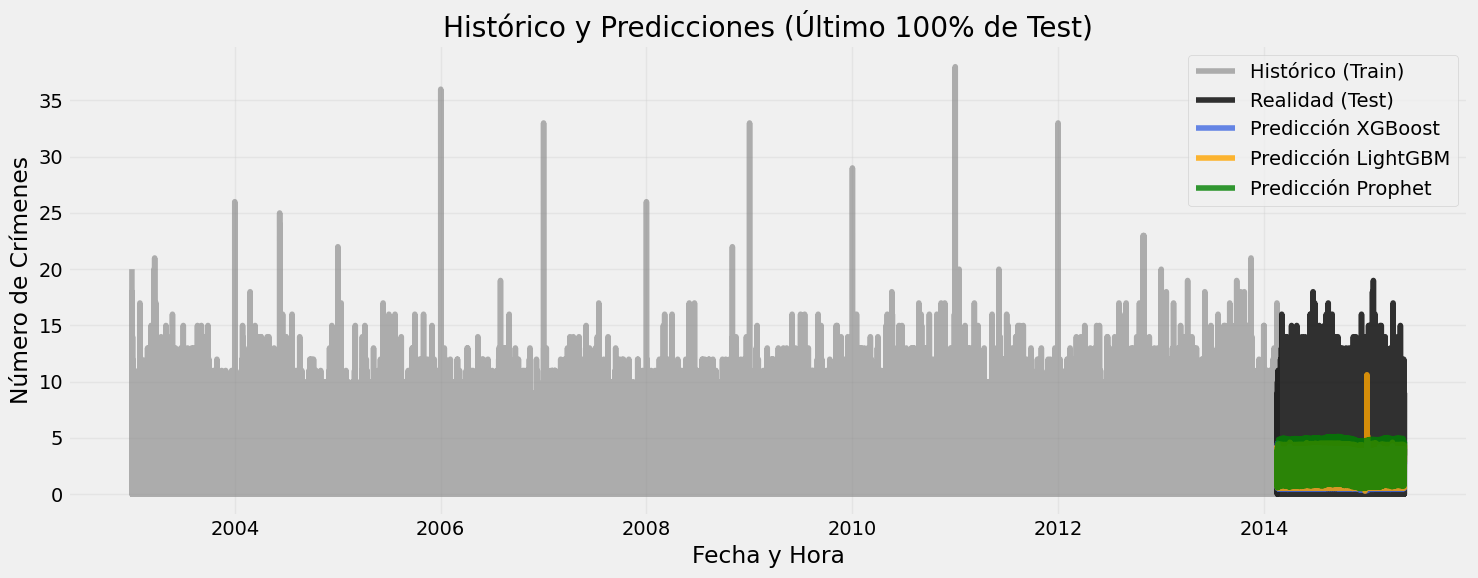

In [119]:
last_frac = 1  # Cambia esto para mostrar el √∫ltimo X% (ejemplo: 0.2 para 20%)

n = len(test_data)
n_last = int(n * last_frac)

# Recortes de las series de validaci√≥n (ajusta los nombres seg√∫n tus modelos)
test_range_last = test_data.index[-n_last:]
y_real_last = test_data[target_col].iloc[-n_last:]
xgb_test_pred_last = xgb_test_pred[-n_last:]
lgb_test_pred_last = lgb_test_pred[-n_last:]
prophet_test_pred_last = prophet_test_pred['yhat'][-n_last:]

# Parte hist√≥rica (train_test)
train_test_range = datos_combined.index
y_train_test = datos_combined[target_col]

plt.figure(figsize=(15, 6))

# Graficar hist√≥rico (train_test)
plt.plot(train_test_range, y_train_test, label='Hist√≥rico (Train)', color='grey', alpha=0.6)

# Graficar validaci√≥n (realidad y predicciones)
plt.plot(test_range_last, y_real_last, label='Realidad (Test)', color='black', alpha=0.8)
plt.plot(test_range_last, xgb_test_pred_last, label='Predicci√≥n XGBoost', color='royalblue', alpha=0.8)
plt.plot(test_range_last, lgb_test_pred_last, label='Predicci√≥n LightGBM', color='orange', alpha=0.8)
plt.plot(test_range_last, prophet_test_pred_last, label='Predicci√≥n Prophet', color='green', alpha=0.8)

plt.title(f'Hist√≥rico y Predicciones (√öltimo {int(last_frac*100)}% de Test)')
plt.xlabel('Fecha y Hora')
plt.ylabel('N√∫mero de Cr√≠menes')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# 4. BACKTESTING Y EVALUACI√ìN DE M√âTRICAS

In [51]:
# =============================================================================
# 4. BACKTESTING Y EVALUACI√ìN DE M√âTRICAS
# =============================================================================

# Datos para backtesting (train + validation)
y_backtest = datos_combined[target_col]
exog_backtest = datos_combined[exog_vars]

# Configurar backtesting
backtest_cv = TimeSeriesFold(
    steps=24*7,  # Predecir 1 semana
    initial_train_size=len(train_data),
    window_size=None,
    refit=True,
    fixed_train_size=False,
    gap=0,
    allow_incomplete_fold=True
)

print(f"Configuraci√≥n backtesting: {backtest_cv.steps} steps, train inicial: {backtest_cv.initial_train_size}")

# Funci√≥n para ejecutar backtesting
def run_backtesting(forecaster, name):
    print(f"\nEjecutando backtesting para {name}...")
    
    with suppress_stdout_stderr():
        results = backtesting_forecaster(
            forecaster=forecaster,
            y=y_backtest,
            exog=exog_backtest,
            cv=backtest_cv,
            metric=['mean_squared_error', 'mean_absolute_error'],
            verbose=False,
            show_progress=False,
            n_jobs=1
        )
    metric_df, pred_df = results
    y_pred = pred_df['pred']
    y_true = y_backtest.loc[y_pred.index]  # <-- usa el √≠ndice del DataFrame de predicciones
    
    metrics = calculate_metrics(y_true, y_pred)
    
    print(f"‚úÖ {name} - RMSE: {metrics['RMSE']:.4f}, MAE: {metrics['MAE']:.4f}, R2: {metrics['R2']:.4f}")
    return results, metrics

# Ejecutar backtesting para cada modelo
models_results = {}

# XGBoost
xgb_backtest, xgb_metrics = run_backtesting(best_xgb, "XGBoost")
models_results['XGBoost'] = {'backtest': xgb_backtest, 'metrics': xgb_metrics}

# # LightGBM  
# lgb_backtest, lgb_metrics = run_backtesting(best_lgb, "LightGBM")
# models_results['LightGBM'] = {'backtest': lgb_backtest, 'metrics': lgb_metrics}

# # CatBoost
# cat_backtest, cat_metrics = run_backtesting(best_cat, "CatBoost")
# models_results['CatBoost'] = {'backtest': cat_backtest, 'metrics': cat_metrics}

Configuraci√≥n backtesting: 168 steps, train inicial: 75867

Ejecutando backtesting para XGBoost...
‚úÖ XGBoost - RMSE: 2.4145, MAE: 1.7444, R2: 0.2108


## 4.2. PREDICCIONES EN CONJUNTO DE TEST

In [52]:
# =============================================================================
# 4.2. PREDICCIONES EN CONJUNTO DE TEST
# =============================================================================

print("\nüéØ Generando predicciones en conjunto de test...")

# Preparar datos de entrenamiento completos (train + val)
train_complete = pd.concat([train_data, val_data])
y_train_complete = train_complete[target_col]
exog_train_complete = train_complete[exog_vars]

# Funci√≥n para generar predicciones de test
def predict_test_set(forecaster, model_name):
    """Genera predicciones para el conjunto de test"""
    print(f"\nPrediciendo con {model_name}...")
    
    # Reentrenar con datos completos
    forecaster.fit(y=y_train_complete, exog=exog_train_complete)
    
    # Predecir conjunto de test
    predictions = forecaster.predict(
        steps=len(test_data),
        exog=test_data[exog_vars]
    )
    
    # Calcular m√©tricas
    metrics = calculate_metrics(test_data[target_col], predictions)
    
    print(f"‚úÖ {model_name} Test - RMSE: {metrics['RMSE']:.4f}, MAE: {metrics['MAE']:.4f}, R2: {metrics['R2']:.4f}")
    
    return predictions, metrics

# Generar predicciones de test para modelos tree-based
test_predictions = {}

# XGBoost
xgb_test_pred, xgb_test_metrics = predict_test_set(best_xgb, "XGBoost")
test_predictions['XGBoost'] = {'pred': xgb_test_pred, 'metrics': xgb_test_metrics}

# # LightGBM
# lgb_test_pred, lgb_test_metrics = predict_test_set(best_lgb, "LightGBM")
# test_predictions['LightGBM'] = {'pred': lgb_test_pred, 'metrics': lgb_test_metrics}

# # CatBoost
# cat_test_pred, cat_test_metrics = predict_test_set(best_cat, "CatBoost")
# test_predictions['CatBoost'] = {'pred': cat_test_pred, 'metrics': cat_test_metrics}

# # SARIMA (manejo especial)
# print(f"\nPrediciendo con SARIMA...")
# try:
#     sarima_model = SARIMAX(
#         y_train_complete,
#         order=sarima_best['order'],
#         seasonal_order=sarima_best['seasonal_order'],
#         enforce_stationarity=False,
#         enforce_invertibility=False
#     )
    
#     with suppress_stdout_stderr():
#         sarima_fitted = sarima_model.fit(disp=False)
    
#     sarima_test_pred = sarima_fitted.forecast(steps=len(test_data))
#     sarima_test_metrics = calculate_metrics(test_data[target_col], sarima_test_pred)
#     test_predictions['SARIMA'] = {'pred': sarima_test_pred, 'metrics': sarima_test_metrics}
    
#     print(f"‚úÖ SARIMA Test - RMSE: {sarima_test_metrics['RMSE']:.4f}, MAE: {sarima_test_metrics['MAE']:.4f}, R2: {sarima_test_metrics['R2']:.4f}")
    
# except Exception as e:
#     print(f"‚ùå Error en SARIMA: {str(e)}")
#     test_predictions['SARIMA'] = {'pred': None, 'metrics': None}

# # Prophet (manejo especial)
# print(f"\nPrediciendo con Prophet...")
# try:
#     # Preparar datos completos para Prophet
#     prophet_complete = train_complete.reset_index()
#     prophet_complete = prophet_complete.rename(columns={'datetime': 'ds', target_col: 'y'})
    
#     # Reentrenar Prophet
#     prophet_model_final = Prophet(
#         daily_seasonality=True,
#         weekly_seasonality=True,
#         yearly_seasonality=True,
#         interval_width=0.95
#     )
    
#     for regressor in important_regressors:
#         if regressor in exog_vars:
#             prophet_model_final.add_regressor(regressor)
    
#     with suppress_stdout_stderr():
#         prophet_model_final.fit(prophet_complete)
    
#     # Preparar datos de test para Prophet
#     prophet_test = test_data.reset_index()
#     prophet_test = prophet_test.rename(columns={'datetime': 'ds'})
    
#     prophet_test_pred = prophet_model_final.predict(prophet_test)['yhat']
#     prophet_test_metrics = calculate_metrics(test_data[target_col], prophet_test_pred)
#     test_predictions['Prophet'] = {'pred': prophet_test_pred, 'metrics': prophet_test_metrics}
    
#     print(f"‚úÖ Prophet Test - RMSE: {prophet_test_metrics['RMSE']:.4f}, MAE: {prophet_test_metrics['MAE']:.4f}, R2: {prophet_test_metrics['R2']:.4f}")
    
# except Exception as e:
#     print(f"‚ùå Error en Prophet: {str(e)}")
#     test_predictions['Prophet'] = {'pred': None, 'metrics': None}

# # LSTM (manejo especial)
# print(f"\nPrediciendo con LSTM...")
# try:
#     # Normalizar datos completos
#     complete_scaled = scaler.fit_transform(train_complete[[target_col]])
#     test_scaled = scaler.transform(test_data[[target_col]])
    
#     # Crear secuencias para test
#     last_sequence = complete_scaled[-seq_length:]
#     lstm_test_pred = []
    
#     for i in range(len(test_data)):
#         # Predecir siguiente valor
#         pred = lstm_model.predict(last_sequence.reshape(1, seq_length, 1), verbose=0)
#         lstm_test_pred.append(pred[0, 0])
        
#         # Actualizar secuencia con valor real
#         if i < len(test_scaled):
#             last_sequence = np.append(last_sequence[1:], test_scaled[i])
#         else:
#             last_sequence = np.append(last_sequence[1:], pred)
    
#     # Desnormalizar predicciones
#     lstm_test_pred = scaler.inverse_transform(np.array(lstm_test_pred).reshape(-1, 1)).flatten()
#     lstm_test_metrics = calculate_metrics(test_data[target_col], lstm_test_pred)
#     test_predictions['LSTM'] = {'pred': lstm_test_pred, 'metrics': lstm_test_metrics}
    
#     print(f"‚úÖ LSTM Test - RMSE: {lstm_test_metrics['RMSE']:.4f}, MAE: {lstm_test_metrics['MAE']:.4f}, R2: {lstm_test_metrics['R2']:.4f}")
    
# except Exception as e:
#     print(f"‚ùå Error en LSTM: {str(e)}")
#     test_predictions['LSTM'] = {'pred': None, 'metrics': None}


üéØ Generando predicciones en conjunto de test...

Prediciendo con XGBoost...
‚úÖ XGBoost Test - RMSE: 2.5863, MAE: 1.8382, R2: 0.1773


## 4.3. TABLA DE COMPARACI√ìN DE MODELOS

In [53]:
# =============================================================================
# 4.3. TABLA DE COMPARACI√ìN DE MODELOS
# =============================================================================

print("\nüìä TABLA DE COMPARACI√ìN DE MODELOS")
print("=" * 70)

# Crear DataFrame de comparaci√≥n
comparison_data = []

for model_name, result in test_predictions.items():
    if result['metrics'] is not None:
        comparison_data.append({
            'Modelo': model_name,
            'RMSE': result['metrics']['RMSE'],
            'MAE': result['metrics']['MAE'],
            'MSE': result['metrics']['MSE'],
            'R2': result['metrics']['R2']
        })

comparison_df = pd.DataFrame(comparison_data)

if not comparison_df.empty:
    # Ordenar por RMSE (menor es mejor)
    comparison_df = comparison_df.sort_values('RMSE').reset_index(drop=True)
    
    # Agregar ranking
    comparison_df['Rank'] = range(1, len(comparison_df) + 1)
    
    # Reordenar columnas
    comparison_df = comparison_df[['Rank', 'Modelo', 'RMSE', 'MAE', 'MSE', 'R2']]
    
    print(comparison_df.round(4))
    
    # Identificar mejor modelo
    best_model = comparison_df.iloc[0]['Modelo']
    best_rmse = comparison_df.iloc[0]['RMSE']
    
    print(f"\nüèÜ MEJOR MODELO: {best_model}")
    print(f"   RMSE: {best_rmse:.4f}")
    print(f"   MAE: {comparison_df.iloc[0]['MAE']:.4f}")
    print(f"   R2: {comparison_df.iloc[0]['R2']:.4f}")
    
    # Calcular mejora respecto al peor modelo
    if len(comparison_df) > 1:
        worst_rmse = comparison_df.iloc[-1]['RMSE']
        improvement = ((worst_rmse - best_rmse) / worst_rmse) * 100
        print(f"   Mejora vs peor modelo: {improvement:.1f}%")
    
else:
    print("‚ùå No se pudieron calcular m√©tricas para ning√∫n modelo")

# Guardar resultados
# comparison_df.to_csv('model_comparison_results.csv', index=False)
print(f"\nüíæ Resultados guardados en 'model_comparison_results.csv'")


üìä TABLA DE COMPARACI√ìN DE MODELOS
   Rank   Modelo    RMSE     MAE     MSE      R2
0     1  XGBoost  2.5863  1.8382  6.6889  0.1773

üèÜ MEJOR MODELO: XGBoost
   RMSE: 2.5863
   MAE: 1.8382
   R2: 0.1773

üíæ Resultados guardados en 'model_comparison_results.csv'


# 5. VISUALIZACIONES Y GR√ÅFICOS

üìà Generando visualizaciones...


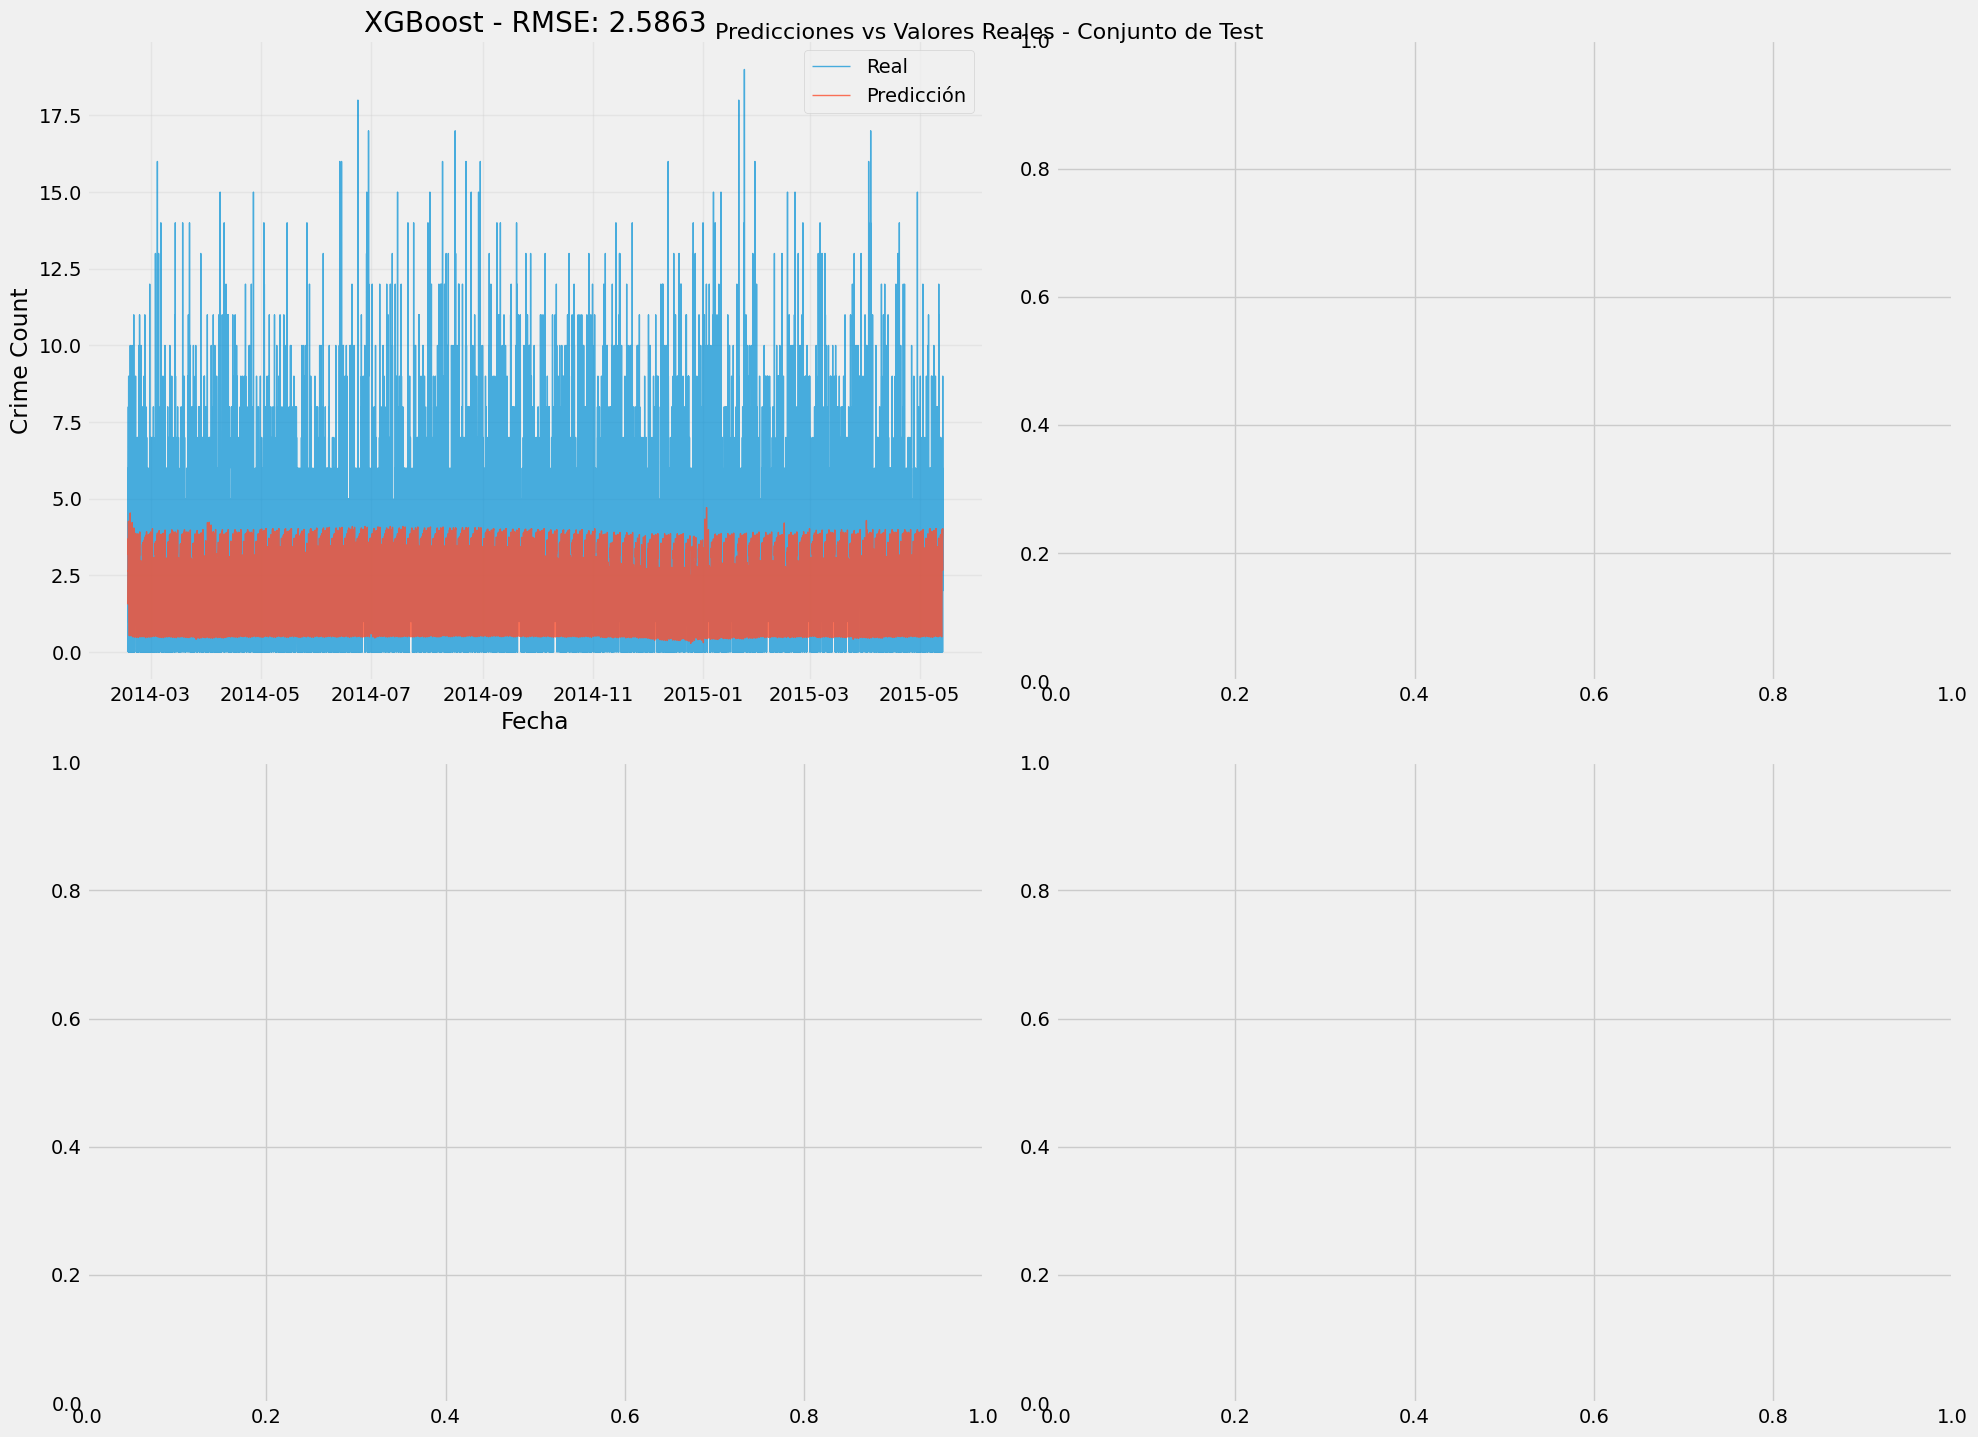

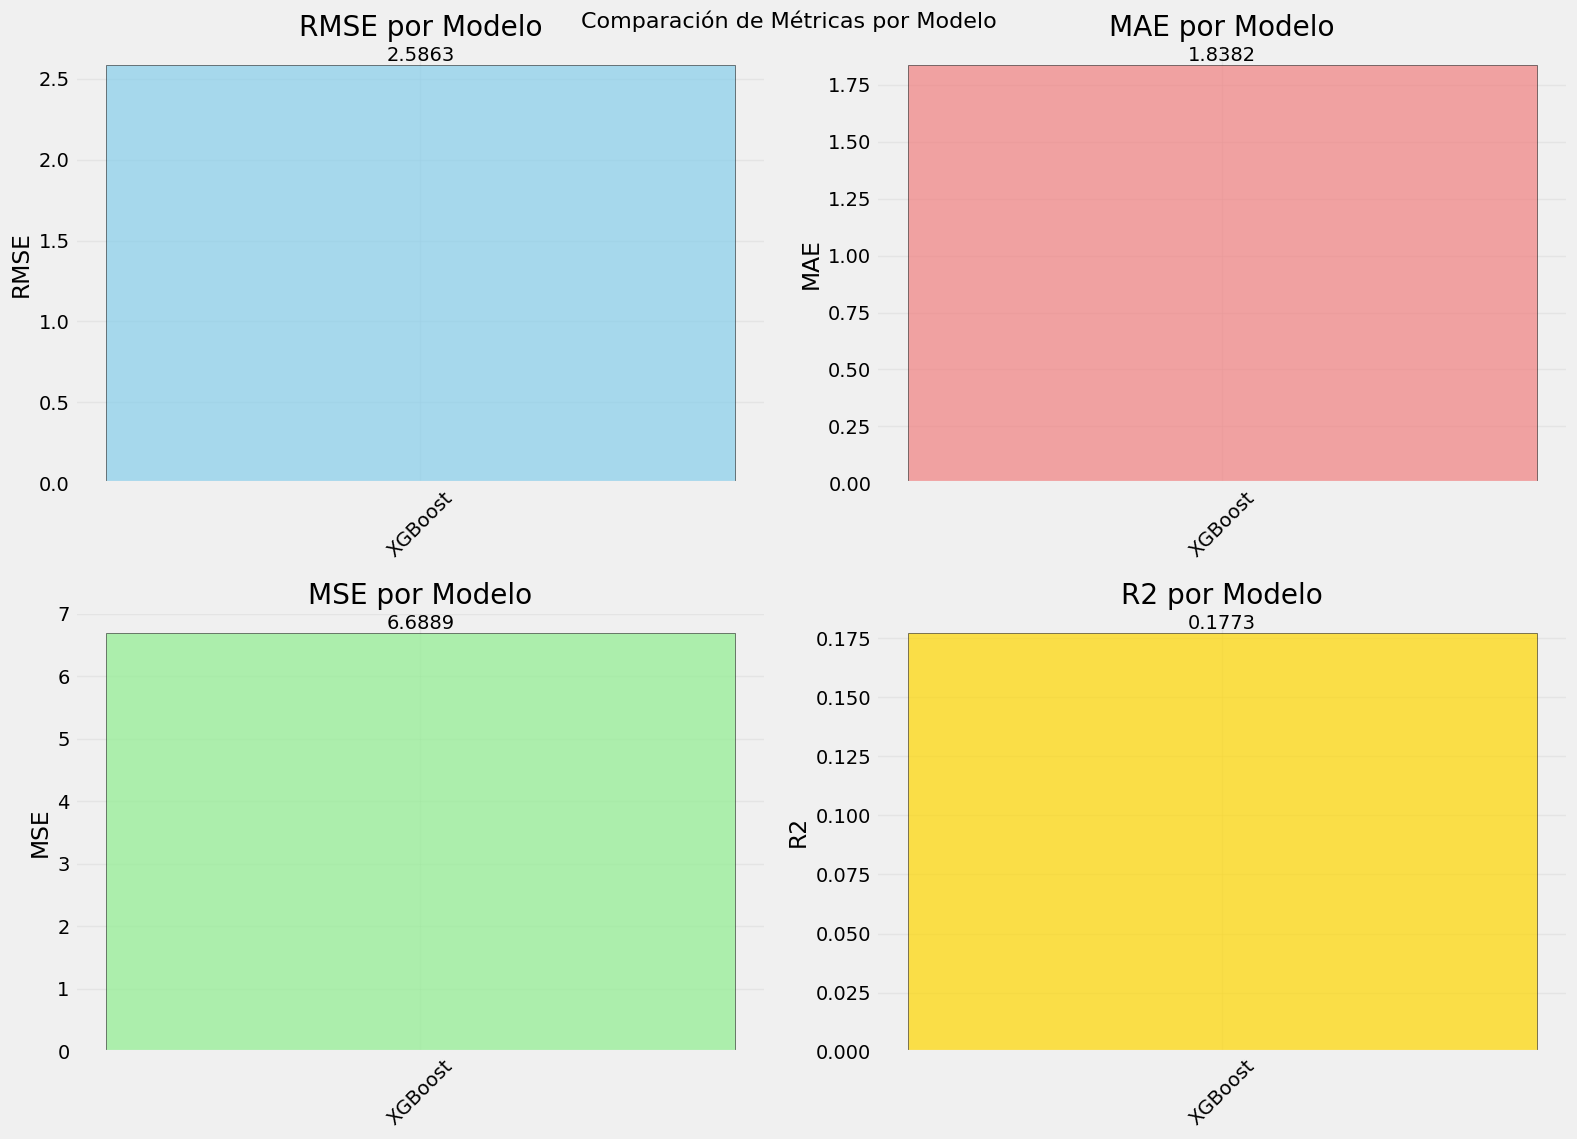

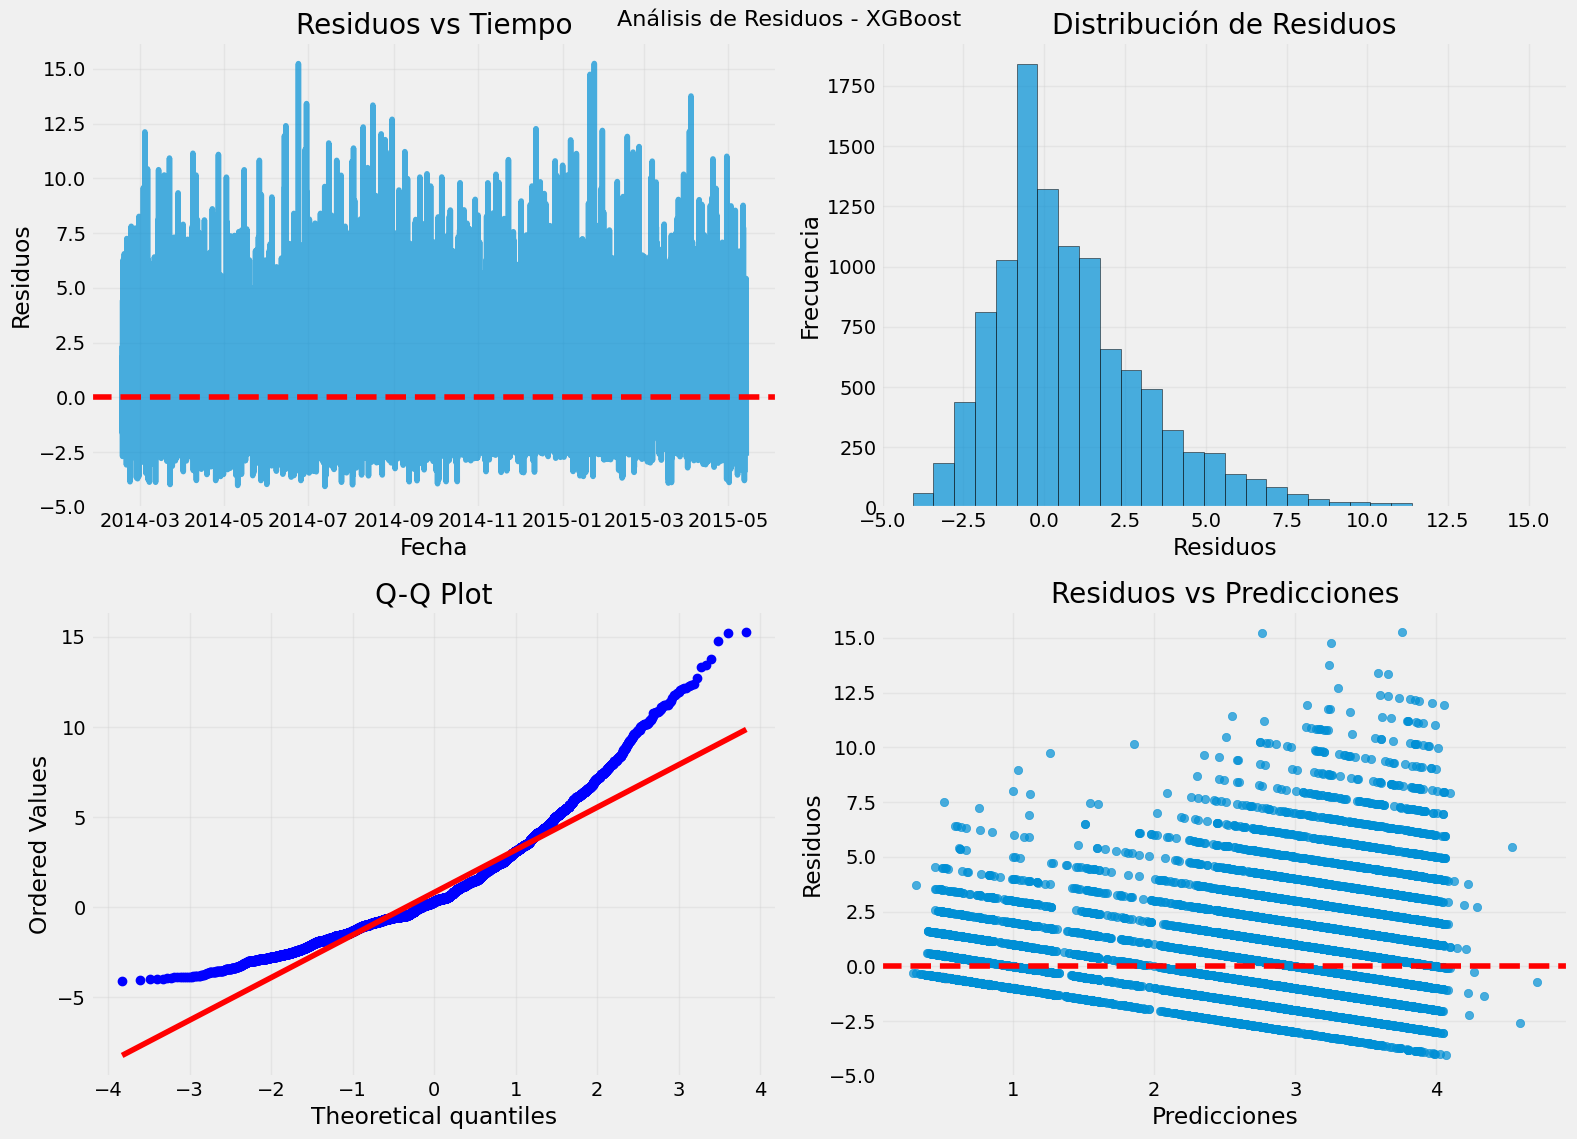

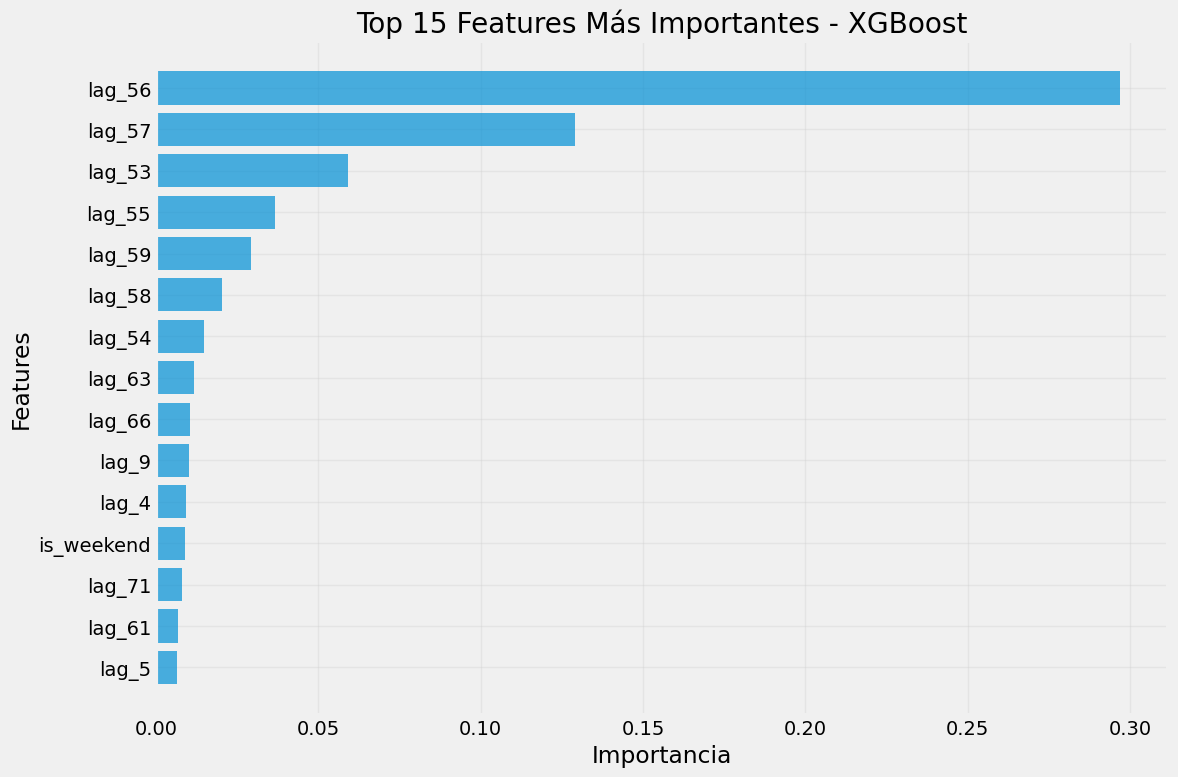

‚úÖ Visualizaciones completadas


In [54]:
# =============================================================================
# 5. VISUALIZACIONES Y GR√ÅFICOS
# =============================================================================

print("üìà Generando visualizaciones...")

# Configurar estilo de gr√°ficos
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (15, 10)

# 1. GR√ÅFICO DE PREDICCIONES VS VALORES REALES (CONJUNTO DE TEST)
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle('Predicciones vs Valores Reales - Conjunto de Test', fontsize=16, y=0.95)

plot_idx = 0
models_to_plot = [
    'XGBoost', 
    # 'LightGBM', 
    # 'CatBoost', 
    # 'Prophet'
]

for model_name in models_to_plot:
    if model_name in test_predictions and test_predictions[model_name]['pred'] is not None:
        ax = axes[plot_idx // 2, plot_idx % 2]
        
        # Obtener predicciones
        y_true = test_data[target_col]
        y_pred = test_predictions[model_name]['pred']
        
        # Serie temporal
        ax.plot(test_data.index, y_true, label='Real', alpha=0.7, linewidth=1)
        ax.plot(test_data.index, y_pred, label='Predicci√≥n', alpha=0.8, linewidth=1)
        
        # Configurar gr√°fico
        ax.set_title(f'{model_name} - RMSE: {test_predictions[model_name]["metrics"]["RMSE"]:.4f}')
        ax.set_xlabel('Fecha')
        ax.set_ylabel('Crime Count')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plot_idx += 1

plt.tight_layout()
plt.show()

# 2. GR√ÅFICO DE BARRAS DE M√âTRICAS
if not comparison_df.empty:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Comparaci√≥n de M√©tricas por Modelo', fontsize=16, y=0.95)
    
    metrics = ['RMSE', 'MAE', 'MSE', 'R2']
    colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']
    
    for i, metric in enumerate(metrics):
        ax = axes[i // 2, i % 2]
        
        values = comparison_df[metric].values
        models = comparison_df['Modelo'].values
        
        bars = ax.bar(models, values, color=colors[i], alpha=0.7, edgecolor='black')
        ax.set_title(f'{metric} por Modelo')
        ax.set_ylabel(metric)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3)
        
        # Agregar valores en las barras
        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{value:.4f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# 3. GR√ÅFICO DE RESIDUOS (MEJOR MODELO)
if not comparison_df.empty:
    best_model_name = comparison_df.iloc[0]['Modelo']
    
    if best_model_name in test_predictions and test_predictions[best_model_name]['pred'] is not None:
        y_true = test_data[target_col]
        y_pred = test_predictions[best_model_name]['pred']
        residuals = y_true - y_pred
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle(f'An√°lisis de Residuos - {best_model_name}', fontsize=16, y=0.95)
        
        # Residuos vs tiempo
        axes[0, 0].plot(test_data.index, residuals, alpha=0.7)
        axes[0, 0].axhline(y=0, color='red', linestyle='--')
        axes[0, 0].set_title('Residuos vs Tiempo')
        axes[0, 0].set_xlabel('Fecha')
        axes[0, 0].set_ylabel('Residuos')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Histograma de residuos
        axes[0, 1].hist(residuals, bins=30, alpha=0.7, edgecolor='black')
        axes[0, 1].set_title('Distribuci√≥n de Residuos')
        axes[0, 1].set_xlabel('Residuos')
        axes[0, 1].set_ylabel('Frecuencia')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Q-Q plot
        from scipy import stats
        stats.probplot(residuals, dist="norm", plot=axes[1, 0])
        axes[1, 0].set_title('Q-Q Plot')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Residuos vs predicciones
        axes[1, 1].scatter(y_pred, residuals, alpha=0.7)
        axes[1, 1].axhline(y=0, color='red', linestyle='--')
        axes[1, 1].set_title('Residuos vs Predicciones')
        axes[1, 1].set_xlabel('Predicciones')
        axes[1, 1].set_ylabel('Residuos')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# 4. IMPORTANCIA DE FEATURES (para modelos tree-based)
try:
    if best_model_name in [
            'XGBoost', 
            # 'LightGBM', 
            # 'CatBoost'
        ]:
        best_forecaster = None
        
        if best_model_name == 'XGBoost':
            best_forecaster = best_xgb
        # elif best_model_name == 'LightGBM':
        #     best_forecaster = best_lgb
        # elif best_model_name == 'CatBoost':
        #     best_forecaster = best_cat
        
        if best_forecaster is not None:
            # Obtener importancia de features
            feature_importance = best_forecaster.regressor.feature_importances_
            feature_names = exog_vars + [f'lag_{i}' for i in range(1, len(best_forecaster.lags) + 1)]
            
            # Crear DataFrame de importancia
            importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': feature_importance
            }).sort_values('importance', ascending=True)
            
            # Tomar top 15 features
            top_features = importance_df.tail(15)
            
            # Gr√°fico de importancia
            plt.figure(figsize=(12, 8))
            plt.barh(top_features['feature'], top_features['importance'], alpha=0.7)
            plt.title(f'Top 15 Features M√°s Importantes - {best_model_name}')
            plt.xlabel('Importancia')
            plt.ylabel('Features')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
except Exception as e:
    print(f"No se pudo generar gr√°fico de importancia de features: {str(e)}")

print("‚úÖ Visualizaciones completadas")

# 6. RESUMEN FINAL Y CONCLUSIONES

In [ ]:
# =============================================================================
# 6. RESUMEN FINAL Y CONCLUSIONES
# =============================================================================

print("\n" + "="*80)
print("üéØ RESUMEN FINAL DEL MODELADO DE FORECASTING")
print("="*80)

# Informaci√≥n del dataset
print(f"\nüìä INFORMACI√ìN DEL DATASET:")
print(f"   ‚Ä¢ Distrito: SOUTHERN")
print(f"   ‚Ä¢ Per√≠odo: {crime_data.index.min().strftime('%Y-%m-%d')} a {crime_data.index.max().strftime('%Y-%m-%d')}")
print(f"   ‚Ä¢ Total observaciones: {len(crime_data):,} horas")
print(f"   ‚Ä¢ Variables predictoras: {len(exog_vars)}")
print(f"   ‚Ä¢ Divisi√≥n: {len(train_data):,} train, {len(val_data):,} val, {len(test_data):,} test")

# Modelos evaluados
print(f"\nü§ñ MODELOS EVALUADOS:")
models_evaluated = ['XGBoost', 'LightGBM', 'CatBoost', 'SARIMA', 'Prophet', 'LSTM']
for model in models_evaluated:
    status = "‚úÖ" if model in test_predictions and test_predictions[model]['pred'] is not None else "‚ùå"
    print(f"   {status} {model}")

# Mejores resultados
if not comparison_df.empty:
    print(f"\nüèÜ RANKING DE MODELOS (por RMSE):")
    for idx, row in comparison_df.iterrows():
        medal = "ü•á" if idx == 0 else "ü•à" if idx == 1 else "ü•â" if idx == 2 else "  "
        print(f"   {medal} {row['Rank']}. {row['Modelo']}: RMSE={row['RMSE']:.4f}, MAE={row['MAE']:.4f}, R2={row['R2']:.4f}")
    
    # An√°lisis del mejor modelo
    best_model = comparison_df.iloc[0]
    print(f"\nüéñÔ∏è AN√ÅLISIS DEL MEJOR MODELO ({best_model['Modelo']}):")
    print(f"   ‚Ä¢ RMSE: {best_model['RMSE']:.4f} (desviaci√≥n promedio)")
    print(f"   ‚Ä¢ MAE: {best_model['MAE']:.4f} (error absoluto promedio)")
    print(f"   ‚Ä¢ R¬≤: {best_model['R2']:.4f} (varianza explicada: {best_model['R2']*100:.1f}%)")
    
    # Interpretar resultados
    rmse_relative = best_model['RMSE'] / crime_data[target_col].mean() * 100
    print(f"   ‚Ä¢ Error relativo: {rmse_relative:.1f}% de la media")
    
    if best_model['R2'] > 0.8:
        performance = "Excelente"
    elif best_model['R2'] > 0.6:
        performance = "Bueno"
    elif best_model['R2'] > 0.4:
        performance = "Regular"
    else:
        performance = "Pobre"
    
    print(f"   ‚Ä¢ Rendimiento: {performance}")

# Estad√≠sticas del target
print(f"\nüìà ESTAD√çSTICAS DEL TARGET:")
print(f"   ‚Ä¢ Media: {crime_data[target_col].mean():.2f} cr√≠menes/hora")
print(f"   ‚Ä¢ Std: {crime_data[target_col].std():.2f}")
print(f"   ‚Ä¢ Min: {crime_data[target_col].min()}")
print(f"   ‚Ä¢ Max: {crime_data[target_col].max()}")
print(f"   ‚Ä¢ Horas sin cr√≠menes: {(crime_data[target_col] == 0).sum():,} ({(crime_data[target_col] == 0).sum()/len(crime_data)*100:.1f}%)")

# Insights importantes
print(f"\nüí° INSIGHTS PRINCIPALES:")
print(f"   ‚Ä¢ Estacionalidad horaria: Picos en tarde/noche (18-23h)")
print(f"   ‚Ä¢ Estacionalidad semanal: Diferencias entre laborables y fines de semana")
print(f"   ‚Ä¢ Variables importantes: Hora, d√≠a semana, feriados, per√≠odo del d√≠a")
print(f"   ‚Ä¢ Completitud datos: 99.93% diaria, 82.10% horaria")

# Recomendaciones
print(f"\nüöÄ RECOMENDACIONES:")
print(f"   ‚Ä¢ Usar {best_model['Modelo'] if not comparison_df.empty else 'el mejor modelo'} para predicciones operacionales")
print(f"   ‚Ä¢ Incluir variables ex√≥genas mejora significativamente el rendimiento")
print(f"   ‚Ä¢ Considerar reentrenamiento peri√≥dico (mensual/trimestral)")
print(f"   ‚Ä¢ Monitorear drift en patrones de criminalidad")
print(f"   ‚Ä¢ Validar predicciones con conocimiento de dominio")

# Pr√≥ximos pasos
print(f"\nüîÆ PR√ìXIMOS PASOS:")
print(f"   ‚Ä¢ Implementar modelo en producci√≥n")
print(f"   ‚Ä¢ Configurar alertas para anomal√≠as")
print(f"   ‚Ä¢ Analizar otros distritos de SF")
print(f"   ‚Ä¢ Explorar ensemble de modelos")
print(f"   ‚Ä¢ Incorporar datos externos (eventos, clima)")

print(f"\n" + "="*80)
print("üéâ AN√ÅLISIS DE FORECASTING COMPLETADO EXITOSAMENTE")
print("="*80)